# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

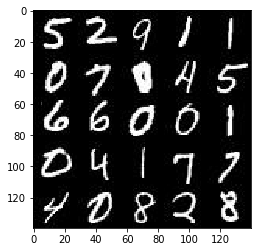

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

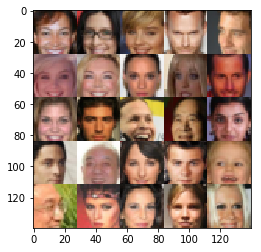

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_placeholder = tf.placeholder(tf.float32, shape=(None,image_width,image_height,image_channels))
    z_placeholder = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_placeholder = tf.placeholder(tf.float32,shape=())

    return real_placeholder, z_placeholder, learning_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        # First layer. (None, 28, 28, 3)
        x1 = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, padding="same", strides=2)
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second layer. (None, 14,14,32)
        x2 = tf.layers.conv2d(inputs=x1, filters=64, kernel_size=5, padding="same", strides=2)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Third layer. (None,7,7,64)
        x3 = tf.layers.conv2d(inputs=x2, filters=128, kernel_size=5, padding="same", strides=2)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        # Output layer. ()
        flat = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(flat,units=1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=(not is_train)):
        
        # First Layer 
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second Layer (7,7,512)
        x2 = tf.layers.conv2d_transpose(x1,filters=256,kernel_size=5, strides=2,padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Third layer (14,14,256)
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        # Output (28,28,128)
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=1, padding="same")
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, padding="same")
    
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if "discriminator" in var.name]
    g_vars = [var for var in t_vars if "generator" in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, losses = [], []
    steps = 0
    if data_image_mode=="RGB":
        num_channel=3
    elif data_image_mode=="L":
        num_channel=1
    
    input_real, input_z, learning_p = model_inputs(image_channels=num_channel,image_width=28,
                                                      image_height=28,z_dim=z_dim)
    
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z,out_channel_dim=num_channel)
    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, beta1=beta1,learning_rate=learning_rate)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random Noise for generator
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count), 
                         "Discriminator loss: {:.4f}...".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g)
                         )
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    s = show_generator_output(sess=sess,n_images=16,input_z=input_z, 
                                          image_mode=data_image_mode,out_channel_dim=num_channel)
                    samples.append(s)
                    
        saver.save(sess, "./checkpoint/generator.ckpt")
        
    return losses
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator loss: 1.2270... Generator loss: 0.9617
Epoch 0/2... Discriminator loss: 0.3615... Generator loss: 1.9714
Epoch 0/2... Discriminator loss: 1.1998... Generator loss: 4.6910
Epoch 0/2... Discriminator loss: 2.3785... Generator loss: 0.2416
Epoch 0/2... Discriminator loss: 0.1891... Generator loss: 2.2583
Epoch 0/2... Discriminator loss: 0.1271... Generator loss: 2.6737
Epoch 0/2... Discriminator loss: 0.0237... Generator loss: 4.3045
Epoch 0/2... Discriminator loss: 0.0036... Generator loss: 6.9255
Epoch 0/2... Discriminator loss: 0.0164... Generator loss: 5.3197
Epoch 0/2... Discriminator loss: 0.0075... Generator loss: 6.1002


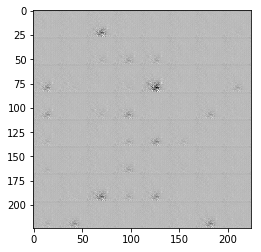

Epoch 0/2... Discriminator loss: 0.0084... Generator loss: 6.1415
Epoch 0/2... Discriminator loss: 0.0045... Generator loss: 7.2357
Epoch 0/2... Discriminator loss: 0.0020... Generator loss: 9.5105
Epoch 0/2... Discriminator loss: 0.0176... Generator loss: 5.0854
Epoch 0/2... Discriminator loss: 0.0292... Generator loss: 8.6060
Epoch 0/2... Discriminator loss: 0.0058... Generator loss: 5.8813
Epoch 0/2... Discriminator loss: 0.0019... Generator loss: 8.5082
Epoch 0/2... Discriminator loss: 0.0044... Generator loss: 6.5133
Epoch 0/2... Discriminator loss: 0.0020... Generator loss: 7.0748
Epoch 0/2... Discriminator loss: 0.0043... Generator loss: 6.8540


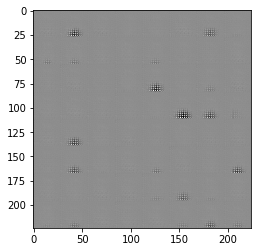

Epoch 0/2... Discriminator loss: 1.8112... Generator loss: 3.4613
Epoch 0/2... Discriminator loss: 0.5230... Generator loss: 2.9140
Epoch 0/2... Discriminator loss: 1.5540... Generator loss: 5.8540
Epoch 0/2... Discriminator loss: 0.2768... Generator loss: 2.3449
Epoch 0/2... Discriminator loss: 0.2264... Generator loss: 2.3542
Epoch 0/2... Discriminator loss: 0.0635... Generator loss: 4.8081
Epoch 0/2... Discriminator loss: 0.0415... Generator loss: 10.5790
Epoch 0/2... Discriminator loss: 4.4893... Generator loss: 15.2466
Epoch 0/2... Discriminator loss: 0.0683... Generator loss: 4.3268
Epoch 0/2... Discriminator loss: 0.0784... Generator loss: 6.1851


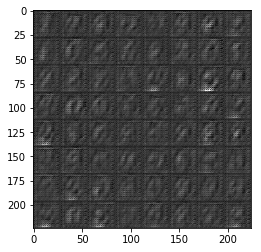

Epoch 0/2... Discriminator loss: 0.6352... Generator loss: 1.4614
Epoch 0/2... Discriminator loss: 0.0988... Generator loss: 3.2714
Epoch 0/2... Discriminator loss: 0.5100... Generator loss: 6.8807
Epoch 0/2... Discriminator loss: 0.1187... Generator loss: 2.7496
Epoch 0/2... Discriminator loss: 0.2606... Generator loss: 2.2370
Epoch 0/2... Discriminator loss: 0.0100... Generator loss: 8.1562
Epoch 0/2... Discriminator loss: 0.0467... Generator loss: 7.9995
Epoch 0/2... Discriminator loss: 2.0415... Generator loss: 0.2353
Epoch 0/2... Discriminator loss: 1.1559... Generator loss: 0.9278
Epoch 0/2... Discriminator loss: 0.6143... Generator loss: 1.4245


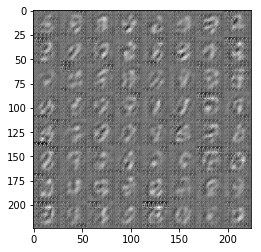

Epoch 0/2... Discriminator loss: 1.8374... Generator loss: 0.8576
Epoch 0/2... Discriminator loss: 1.3837... Generator loss: 0.9263
Epoch 0/2... Discriminator loss: 0.9320... Generator loss: 0.7297
Epoch 0/2... Discriminator loss: 0.4614... Generator loss: 2.4805
Epoch 0/2... Discriminator loss: 0.1956... Generator loss: 3.0094
Epoch 0/2... Discriminator loss: 0.7846... Generator loss: 1.6430
Epoch 0/2... Discriminator loss: 1.5546... Generator loss: 0.3599
Epoch 0/2... Discriminator loss: 1.0548... Generator loss: 0.9687
Epoch 0/2... Discriminator loss: 1.6806... Generator loss: 0.2751
Epoch 0/2... Discriminator loss: 1.3066... Generator loss: 2.1392


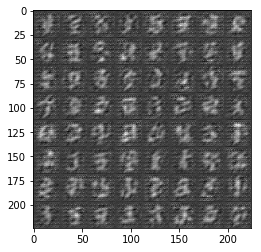

Epoch 0/2... Discriminator loss: 0.6261... Generator loss: 1.3887
Epoch 0/2... Discriminator loss: 1.5844... Generator loss: 0.2912
Epoch 0/2... Discriminator loss: 0.7516... Generator loss: 0.8062
Epoch 0/2... Discriminator loss: 0.0863... Generator loss: 4.1801
Epoch 0/2... Discriminator loss: 0.0720... Generator loss: 4.0107
Epoch 0/2... Discriminator loss: 0.0208... Generator loss: 7.2657
Epoch 0/2... Discriminator loss: 0.0463... Generator loss: 3.8129
Epoch 0/2... Discriminator loss: 1.7910... Generator loss: 0.2832
Epoch 0/2... Discriminator loss: 1.0508... Generator loss: 0.5961
Epoch 0/2... Discriminator loss: 1.0949... Generator loss: 2.6879


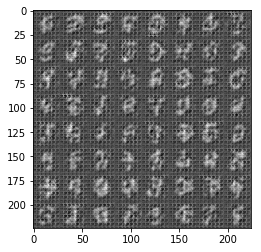

Epoch 0/2... Discriminator loss: 0.7406... Generator loss: 1.1845
Epoch 0/2... Discriminator loss: 0.1614... Generator loss: 2.7583
Epoch 0/2... Discriminator loss: 0.1237... Generator loss: 7.2480
Epoch 0/2... Discriminator loss: 0.0499... Generator loss: 3.9722
Epoch 0/2... Discriminator loss: 0.0309... Generator loss: 6.1114
Epoch 0/2... Discriminator loss: 2.2367... Generator loss: 0.1992
Epoch 0/2... Discriminator loss: 1.0807... Generator loss: 0.8890
Epoch 0/2... Discriminator loss: 1.1713... Generator loss: 0.5504
Epoch 0/2... Discriminator loss: 0.6960... Generator loss: 1.3995
Epoch 0/2... Discriminator loss: 0.8855... Generator loss: 1.0989


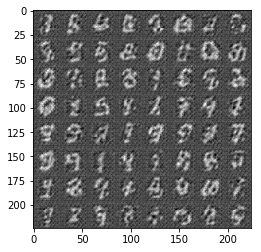

Epoch 0/2... Discriminator loss: 0.7660... Generator loss: 1.4645
Epoch 0/2... Discriminator loss: 0.5734... Generator loss: 3.0123
Epoch 0/2... Discriminator loss: 0.3465... Generator loss: 3.7424
Epoch 0/2... Discriminator loss: 0.9701... Generator loss: 3.8968
Epoch 0/2... Discriminator loss: 0.2147... Generator loss: 4.0241
Epoch 0/2... Discriminator loss: 0.1131... Generator loss: 3.1823
Epoch 0/2... Discriminator loss: 0.2741... Generator loss: 1.8940
Epoch 0/2... Discriminator loss: 0.1903... Generator loss: 2.2066
Epoch 0/2... Discriminator loss: 0.0800... Generator loss: 5.2193
Epoch 0/2... Discriminator loss: 0.1215... Generator loss: 5.0479


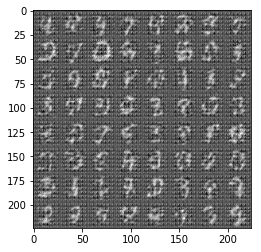

Epoch 0/2... Discriminator loss: 0.2114... Generator loss: 3.2692
Epoch 0/2... Discriminator loss: 0.0349... Generator loss: 4.3401
Epoch 0/2... Discriminator loss: 0.0349... Generator loss: 4.5538
Epoch 0/2... Discriminator loss: 0.0144... Generator loss: 5.8194
Epoch 0/2... Discriminator loss: 0.6842... Generator loss: 5.5995
Epoch 0/2... Discriminator loss: 0.2982... Generator loss: 3.3833
Epoch 0/2... Discriminator loss: 0.9274... Generator loss: 0.8308
Epoch 0/2... Discriminator loss: 0.4660... Generator loss: 1.4325
Epoch 0/2... Discriminator loss: 0.4626... Generator loss: 7.5984
Epoch 0/2... Discriminator loss: 1.9791... Generator loss: 0.2072


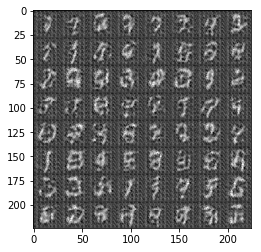

Epoch 0/2... Discriminator loss: 0.7303... Generator loss: 0.8179
Epoch 0/2... Discriminator loss: 0.1295... Generator loss: 3.1816
Epoch 0/2... Discriminator loss: 0.2931... Generator loss: 1.8222
Epoch 0/2... Discriminator loss: 1.2576... Generator loss: 3.3903
Epoch 0/2... Discriminator loss: 1.1719... Generator loss: 0.4576
Epoch 0/2... Discriminator loss: 0.0831... Generator loss: 2.9876
Epoch 0/2... Discriminator loss: 0.2788... Generator loss: 1.8739
Epoch 0/2... Discriminator loss: 0.0907... Generator loss: 9.1429
Epoch 0/2... Discriminator loss: 0.0203... Generator loss: 7.0458
Epoch 0/2... Discriminator loss: 0.0410... Generator loss: 4.1886


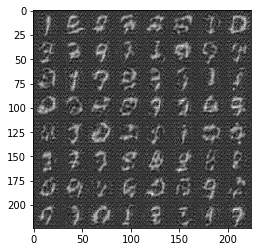

Epoch 0/2... Discriminator loss: 3.0493... Generator loss: 0.0795
Epoch 0/2... Discriminator loss: 0.3653... Generator loss: 1.9355
Epoch 0/2... Discriminator loss: 0.5532... Generator loss: 1.1568
Epoch 0/2... Discriminator loss: 0.1631... Generator loss: 2.2974
Epoch 0/2... Discriminator loss: 4.9180... Generator loss: 0.0182
Epoch 0/2... Discriminator loss: 0.3851... Generator loss: 1.9965
Epoch 0/2... Discriminator loss: 0.4349... Generator loss: 1.4189
Epoch 0/2... Discriminator loss: 0.0358... Generator loss: 5.1059
Epoch 0/2... Discriminator loss: 0.1814... Generator loss: 2.3059
Epoch 0/2... Discriminator loss: 0.1336... Generator loss: 2.6486


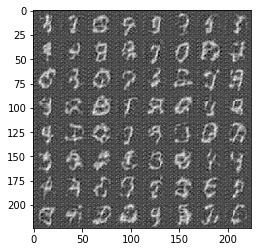

Epoch 0/2... Discriminator loss: 0.0388... Generator loss: 5.4670
Epoch 0/2... Discriminator loss: 0.0180... Generator loss: 4.8640
Epoch 0/2... Discriminator loss: 0.0138... Generator loss: 5.7674
Epoch 0/2... Discriminator loss: 0.0205... Generator loss: 6.7532
Epoch 0/2... Discriminator loss: 0.0487... Generator loss: 5.0629
Epoch 0/2... Discriminator loss: 2.1313... Generator loss: 0.2050
Epoch 0/2... Discriminator loss: 0.6601... Generator loss: 1.0739
Epoch 0/2... Discriminator loss: 0.0674... Generator loss: 3.2486
Epoch 0/2... Discriminator loss: 0.1547... Generator loss: 6.7979
Epoch 0/2... Discriminator loss: 0.1052... Generator loss: 4.0102


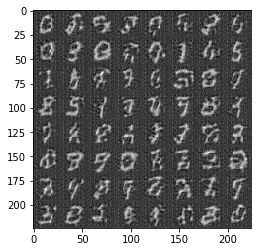

Epoch 0/2... Discriminator loss: 1.5913... Generator loss: 0.6137
Epoch 0/2... Discriminator loss: 0.5423... Generator loss: 1.2921
Epoch 0/2... Discriminator loss: 0.5903... Generator loss: 1.0147
Epoch 0/2... Discriminator loss: 0.3344... Generator loss: 1.6502
Epoch 0/2... Discriminator loss: 0.1856... Generator loss: 2.0844
Epoch 0/2... Discriminator loss: 0.5093... Generator loss: 1.2295
Epoch 0/2... Discriminator loss: 0.1398... Generator loss: 6.6164
Epoch 0/2... Discriminator loss: 0.3887... Generator loss: 2.1103
Epoch 0/2... Discriminator loss: 0.1716... Generator loss: 2.3561
Epoch 0/2... Discriminator loss: 0.6371... Generator loss: 1.0189


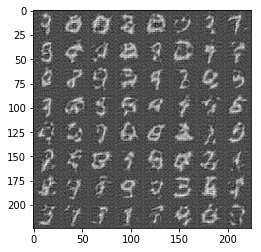

Epoch 0/2... Discriminator loss: 0.7286... Generator loss: 0.8798
Epoch 0/2... Discriminator loss: 0.5208... Generator loss: 2.2229
Epoch 0/2... Discriminator loss: 1.4752... Generator loss: 0.3787
Epoch 0/2... Discriminator loss: 0.5856... Generator loss: 1.5917
Epoch 0/2... Discriminator loss: 0.3021... Generator loss: 2.0462
Epoch 0/2... Discriminator loss: 0.5603... Generator loss: 1.0973
Epoch 0/2... Discriminator loss: 0.0378... Generator loss: 5.5354
Epoch 0/2... Discriminator loss: 0.2715... Generator loss: 1.6841
Epoch 0/2... Discriminator loss: 0.0588... Generator loss: 3.4152
Epoch 0/2... Discriminator loss: 0.0712... Generator loss: 3.5151


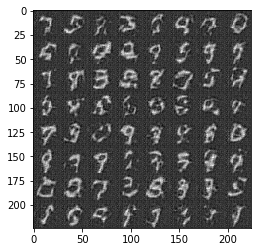

Epoch 0/2... Discriminator loss: 0.6357... Generator loss: 1.0841
Epoch 0/2... Discriminator loss: 0.2611... Generator loss: 1.8183
Epoch 0/2... Discriminator loss: 0.0519... Generator loss: 5.1510
Epoch 0/2... Discriminator loss: 0.0518... Generator loss: 6.2239
Epoch 0/2... Discriminator loss: 0.1584... Generator loss: 2.5837
Epoch 0/2... Discriminator loss: 0.0335... Generator loss: 4.7350
Epoch 0/2... Discriminator loss: 0.0528... Generator loss: 4.4045
Epoch 0/2... Discriminator loss: 0.0275... Generator loss: 6.7823
Epoch 0/2... Discriminator loss: 0.0127... Generator loss: 5.8325
Epoch 0/2... Discriminator loss: 0.0959... Generator loss: 2.7791


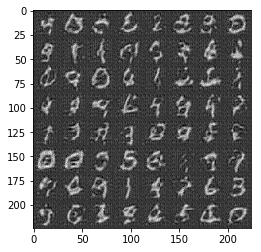

Epoch 0/2... Discriminator loss: 0.0154... Generator loss: 6.3605
Epoch 0/2... Discriminator loss: 0.0853... Generator loss: 2.9066
Epoch 0/2... Discriminator loss: 0.0083... Generator loss: 8.9447
Epoch 0/2... Discriminator loss: 0.0075... Generator loss: 8.9570
Epoch 0/2... Discriminator loss: 0.0109... Generator loss: 7.1124
Epoch 0/2... Discriminator loss: 0.1037... Generator loss: 5.7270
Epoch 0/2... Discriminator loss: 1.0258... Generator loss: 4.3871
Epoch 0/2... Discriminator loss: 0.4506... Generator loss: 1.3133
Epoch 0/2... Discriminator loss: 0.3243... Generator loss: 1.9655
Epoch 0/2... Discriminator loss: 0.3131... Generator loss: 2.0659


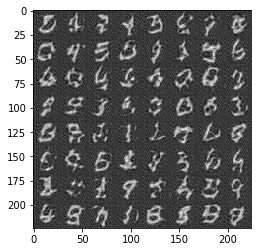

Epoch 0/2... Discriminator loss: 0.2594... Generator loss: 2.0306
Epoch 0/2... Discriminator loss: 0.2505... Generator loss: 1.8725
Epoch 0/2... Discriminator loss: 1.7987... Generator loss: 0.3009
Epoch 0/2... Discriminator loss: 0.2457... Generator loss: 2.8944
Epoch 0/2... Discriminator loss: 0.2341... Generator loss: 2.0734
Epoch 0/2... Discriminator loss: 1.1755... Generator loss: 0.6121
Epoch 0/2... Discriminator loss: 1.3371... Generator loss: 2.0055
Epoch 0/2... Discriminator loss: 0.5309... Generator loss: 1.3680
Epoch 0/2... Discriminator loss: 0.1867... Generator loss: 2.5869
Epoch 0/2... Discriminator loss: 0.0750... Generator loss: 4.3095


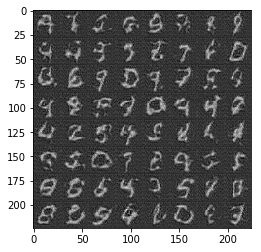

Epoch 0/2... Discriminator loss: 0.5060... Generator loss: 1.2930
Epoch 0/2... Discriminator loss: 0.3839... Generator loss: 1.4360
Epoch 0/2... Discriminator loss: 0.0433... Generator loss: 4.3551
Epoch 0/2... Discriminator loss: 0.2237... Generator loss: 2.1075
Epoch 0/2... Discriminator loss: 0.0615... Generator loss: 3.6704
Epoch 0/2... Discriminator loss: 0.0404... Generator loss: 4.6454
Epoch 0/2... Discriminator loss: 0.0338... Generator loss: 4.7273
Epoch 0/2... Discriminator loss: 0.1074... Generator loss: 2.6968
Epoch 0/2... Discriminator loss: 0.1011... Generator loss: 2.6726
Epoch 0/2... Discriminator loss: 0.0864... Generator loss: 2.9233


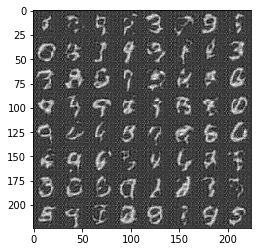

Epoch 0/2... Discriminator loss: 0.0600... Generator loss: 6.7783
Epoch 0/2... Discriminator loss: 0.0236... Generator loss: 4.5432
Epoch 0/2... Discriminator loss: 0.0395... Generator loss: 3.5844
Epoch 0/2... Discriminator loss: 0.0167... Generator loss: 6.6333
Epoch 0/2... Discriminator loss: 0.2128... Generator loss: 2.0220
Epoch 0/2... Discriminator loss: 0.0075... Generator loss: 8.5993
Epoch 0/2... Discriminator loss: 0.0294... Generator loss: 4.3153
Epoch 1/2... Discriminator loss: 0.0048... Generator loss: 6.3744
Epoch 1/2... Discriminator loss: 0.0681... Generator loss: 3.1247
Epoch 1/2... Discriminator loss: 7.4116... Generator loss: 14.2708


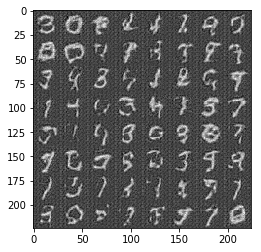

Epoch 1/2... Discriminator loss: 1.0805... Generator loss: 1.2723
Epoch 1/2... Discriminator loss: 1.0375... Generator loss: 0.6995
Epoch 1/2... Discriminator loss: 0.0562... Generator loss: 4.3735
Epoch 1/2... Discriminator loss: 0.0319... Generator loss: 4.9489
Epoch 1/2... Discriminator loss: 0.2227... Generator loss: 1.9666
Epoch 1/2... Discriminator loss: 0.0906... Generator loss: 3.2760
Epoch 1/2... Discriminator loss: 0.0144... Generator loss: 5.7717
Epoch 1/2... Discriminator loss: 0.7197... Generator loss: 4.1840
Epoch 1/2... Discriminator loss: 0.8425... Generator loss: 1.8961
Epoch 1/2... Discriminator loss: 0.3546... Generator loss: 2.3410


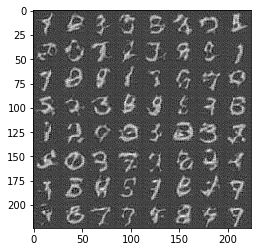

Epoch 1/2... Discriminator loss: 0.5035... Generator loss: 1.4074
Epoch 1/2... Discriminator loss: 0.6501... Generator loss: 2.1144
Epoch 1/2... Discriminator loss: 0.6452... Generator loss: 1.1225
Epoch 1/2... Discriminator loss: 0.1600... Generator loss: 2.4973
Epoch 1/2... Discriminator loss: 0.0980... Generator loss: 3.0723
Epoch 1/2... Discriminator loss: 0.1225... Generator loss: 2.9502
Epoch 1/2... Discriminator loss: 0.2850... Generator loss: 1.8579
Epoch 1/2... Discriminator loss: 4.5872... Generator loss: 7.8433
Epoch 1/2... Discriminator loss: 0.6038... Generator loss: 2.0668
Epoch 1/2... Discriminator loss: 0.8939... Generator loss: 0.7305


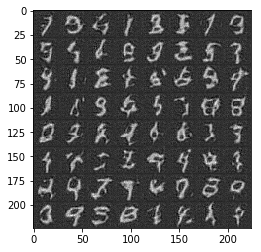

Epoch 1/2... Discriminator loss: 0.8305... Generator loss: 1.7597
Epoch 1/2... Discriminator loss: 0.2636... Generator loss: 1.8890
Epoch 1/2... Discriminator loss: 0.2579... Generator loss: 1.8924
Epoch 1/2... Discriminator loss: 2.3357... Generator loss: 0.2113
Epoch 1/2... Discriminator loss: 0.4595... Generator loss: 1.4868
Epoch 1/2... Discriminator loss: 0.4659... Generator loss: 1.1805
Epoch 1/2... Discriminator loss: 0.3644... Generator loss: 1.4615
Epoch 1/2... Discriminator loss: 0.1559... Generator loss: 2.5787
Epoch 1/2... Discriminator loss: 0.2774... Generator loss: 1.9240
Epoch 1/2... Discriminator loss: 0.2030... Generator loss: 2.5569


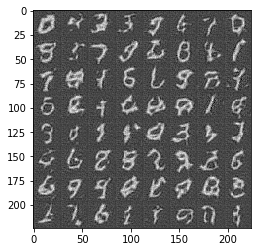

Epoch 1/2... Discriminator loss: 0.1380... Generator loss: 2.7033
Epoch 1/2... Discriminator loss: 0.0354... Generator loss: 3.8752
Epoch 1/2... Discriminator loss: 0.0206... Generator loss: 6.3659
Epoch 1/2... Discriminator loss: 0.0362... Generator loss: 4.4035
Epoch 1/2... Discriminator loss: 0.0220... Generator loss: 4.7428
Epoch 1/2... Discriminator loss: 0.4084... Generator loss: 1.4963
Epoch 1/2... Discriminator loss: 0.0339... Generator loss: 4.0618
Epoch 1/2... Discriminator loss: 0.0571... Generator loss: 4.0671
Epoch 1/2... Discriminator loss: 0.5883... Generator loss: 1.2606
Epoch 1/2... Discriminator loss: 0.7041... Generator loss: 3.7277


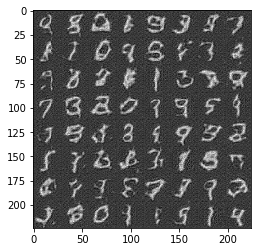

Epoch 1/2... Discriminator loss: 0.4147... Generator loss: 1.6677
Epoch 1/2... Discriminator loss: 0.8332... Generator loss: 0.7990
Epoch 1/2... Discriminator loss: 0.0613... Generator loss: 4.8196
Epoch 1/2... Discriminator loss: 0.1048... Generator loss: 4.3735
Epoch 1/2... Discriminator loss: 0.0384... Generator loss: 4.0359
Epoch 1/2... Discriminator loss: 0.0234... Generator loss: 5.2516
Epoch 1/2... Discriminator loss: 0.1594... Generator loss: 2.3968
Epoch 1/2... Discriminator loss: 0.0328... Generator loss: 4.2927
Epoch 1/2... Discriminator loss: 0.1474... Generator loss: 2.3745
Epoch 1/2... Discriminator loss: 0.5874... Generator loss: 1.2487


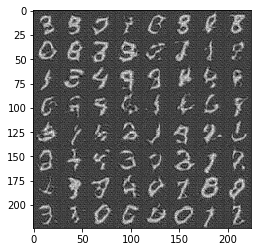

Epoch 1/2... Discriminator loss: 0.0806... Generator loss: 3.2893
Epoch 1/2... Discriminator loss: 0.0586... Generator loss: 3.4972
Epoch 1/2... Discriminator loss: 0.1604... Generator loss: 2.3126
Epoch 1/2... Discriminator loss: 0.0126... Generator loss: 7.8865
Epoch 1/2... Discriminator loss: 0.0031... Generator loss: 7.2577
Epoch 1/2... Discriminator loss: 0.0153... Generator loss: 7.7940
Epoch 1/2... Discriminator loss: 0.0278... Generator loss: 4.3774
Epoch 1/2... Discriminator loss: 0.0328... Generator loss: 4.4216
Epoch 1/2... Discriminator loss: 0.0320... Generator loss: 3.8682
Epoch 1/2... Discriminator loss: 0.1626... Generator loss: 2.3700


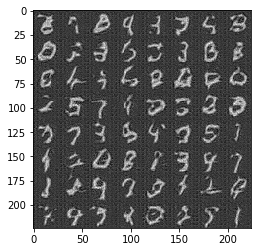

Epoch 1/2... Discriminator loss: 0.5741... Generator loss: 1.1238
Epoch 1/2... Discriminator loss: 0.1024... Generator loss: 2.8381
Epoch 1/2... Discriminator loss: 0.0678... Generator loss: 3.7504
Epoch 1/2... Discriminator loss: 0.0116... Generator loss: 7.0579
Epoch 1/2... Discriminator loss: 0.0025... Generator loss: 8.6976
Epoch 1/2... Discriminator loss: 0.0483... Generator loss: 3.7233
Epoch 1/2... Discriminator loss: 0.0105... Generator loss: 5.7255
Epoch 1/2... Discriminator loss: 0.0134... Generator loss: 8.3045
Epoch 1/2... Discriminator loss: 0.0315... Generator loss: 4.8597
Epoch 1/2... Discriminator loss: 0.1956... Generator loss: 2.0718


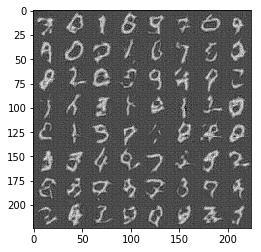

Epoch 1/2... Discriminator loss: 0.0054... Generator loss: 7.4573
Epoch 1/2... Discriminator loss: 0.0660... Generator loss: 3.4256
Epoch 1/2... Discriminator loss: 0.0517... Generator loss: 3.6551
Epoch 1/2... Discriminator loss: 0.0053... Generator loss: 8.9749
Epoch 1/2... Discriminator loss: 0.0387... Generator loss: 3.8136
Epoch 1/2... Discriminator loss: 0.0286... Generator loss: 3.9762
Epoch 1/2... Discriminator loss: 0.0070... Generator loss: 6.5578
Epoch 1/2... Discriminator loss: 0.1063... Generator loss: 2.6633
Epoch 1/2... Discriminator loss: 0.0276... Generator loss: 5.0953
Epoch 1/2... Discriminator loss: 0.0103... Generator loss: 8.5447


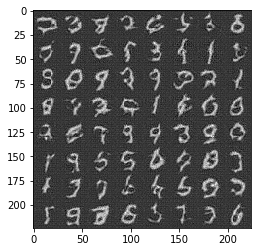

Epoch 1/2... Discriminator loss: 0.0545... Generator loss: 3.5324
Epoch 1/2... Discriminator loss: 9.4387... Generator loss: 0.0004
Epoch 1/2... Discriminator loss: 0.9831... Generator loss: 2.8592
Epoch 1/2... Discriminator loss: 1.0858... Generator loss: 3.7638
Epoch 1/2... Discriminator loss: 0.2485... Generator loss: 2.9116
Epoch 1/2... Discriminator loss: 0.5449... Generator loss: 1.3888
Epoch 1/2... Discriminator loss: 0.2824... Generator loss: 2.7183
Epoch 1/2... Discriminator loss: 0.3989... Generator loss: 2.0963
Epoch 1/2... Discriminator loss: 0.4381... Generator loss: 1.8306
Epoch 1/2... Discriminator loss: 0.3764... Generator loss: 2.4054


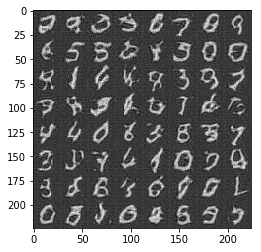

Epoch 1/2... Discriminator loss: 0.5351... Generator loss: 1.3001
Epoch 1/2... Discriminator loss: 0.5679... Generator loss: 1.1627
Epoch 1/2... Discriminator loss: 2.8293... Generator loss: 6.8770
Epoch 1/2... Discriminator loss: 0.7524... Generator loss: 0.9146
Epoch 1/2... Discriminator loss: 0.4326... Generator loss: 1.4050
Epoch 1/2... Discriminator loss: 0.3332... Generator loss: 1.8598
Epoch 1/2... Discriminator loss: 0.2507... Generator loss: 1.9332
Epoch 1/2... Discriminator loss: 3.5995... Generator loss: 0.0388
Epoch 1/2... Discriminator loss: 0.5964... Generator loss: 1.6034
Epoch 1/2... Discriminator loss: 0.9165... Generator loss: 1.0292


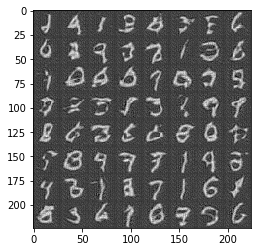

Epoch 1/2... Discriminator loss: 0.4486... Generator loss: 1.9363
Epoch 1/2... Discriminator loss: 0.8463... Generator loss: 0.9703
Epoch 1/2... Discriminator loss: 0.5090... Generator loss: 1.5551
Epoch 1/2... Discriminator loss: 0.2235... Generator loss: 2.1355
Epoch 1/2... Discriminator loss: 0.5960... Generator loss: 3.5899
Epoch 1/2... Discriminator loss: 0.3128... Generator loss: 2.4081
Epoch 1/2... Discriminator loss: 0.3758... Generator loss: 1.9996
Epoch 1/2... Discriminator loss: 0.1968... Generator loss: 2.5992
Epoch 1/2... Discriminator loss: 0.2926... Generator loss: 1.9670
Epoch 1/2... Discriminator loss: 0.1863... Generator loss: 3.4589


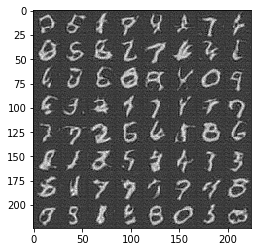

Epoch 1/2... Discriminator loss: 0.1147... Generator loss: 3.2577
Epoch 1/2... Discriminator loss: 0.4685... Generator loss: 1.3230
Epoch 1/2... Discriminator loss: 2.0282... Generator loss: 3.1116
Epoch 1/2... Discriminator loss: 0.5793... Generator loss: 1.7292
Epoch 1/2... Discriminator loss: 0.3111... Generator loss: 2.0737
Epoch 1/2... Discriminator loss: 0.7152... Generator loss: 0.9735
Epoch 1/2... Discriminator loss: 0.6149... Generator loss: 1.1744
Epoch 1/2... Discriminator loss: 1.2020... Generator loss: 0.6000
Epoch 1/2... Discriminator loss: 0.3688... Generator loss: 1.7383
Epoch 1/2... Discriminator loss: 0.3037... Generator loss: 6.1697


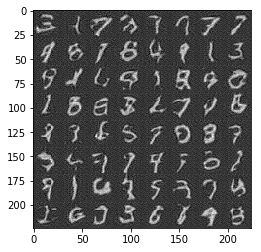

Epoch 1/2... Discriminator loss: 0.1796... Generator loss: 5.4555
Epoch 1/2... Discriminator loss: 0.0889... Generator loss: 3.0118
Epoch 1/2... Discriminator loss: 0.6745... Generator loss: 1.1654
Epoch 1/2... Discriminator loss: 0.1792... Generator loss: 2.5030
Epoch 1/2... Discriminator loss: 0.1187... Generator loss: 3.1958
Epoch 1/2... Discriminator loss: 0.1493... Generator loss: 2.4100
Epoch 1/2... Discriminator loss: 0.1388... Generator loss: 2.6373
Epoch 1/2... Discriminator loss: 0.1566... Generator loss: 2.7794
Epoch 1/2... Discriminator loss: 0.0653... Generator loss: 3.5966
Epoch 1/2... Discriminator loss: 0.1079... Generator loss: 4.6177


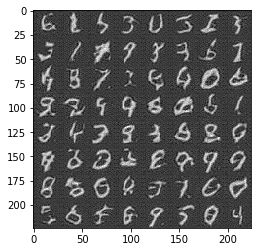

Epoch 1/2... Discriminator loss: 0.1095... Generator loss: 2.6502
Epoch 1/2... Discriminator loss: 0.0114... Generator loss: 5.1486
Epoch 1/2... Discriminator loss: 1.2013... Generator loss: 0.8534
Epoch 1/2... Discriminator loss: 0.9616... Generator loss: 2.2991
Epoch 1/2... Discriminator loss: 0.4104... Generator loss: 2.5983
Epoch 1/2... Discriminator loss: 0.9427... Generator loss: 0.6776
Epoch 1/2... Discriminator loss: 0.1249... Generator loss: 2.8544
Epoch 1/2... Discriminator loss: 0.0337... Generator loss: 4.6235
Epoch 1/2... Discriminator loss: 0.1411... Generator loss: 2.5454
Epoch 1/2... Discriminator loss: 0.0453... Generator loss: 6.7131


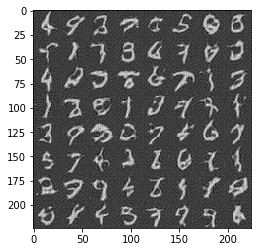

Epoch 1/2... Discriminator loss: 0.2659... Generator loss: 1.9143
Epoch 1/2... Discriminator loss: 0.1426... Generator loss: 2.5953
Epoch 1/2... Discriminator loss: 0.3614... Generator loss: 1.5905
Epoch 1/2... Discriminator loss: 0.0786... Generator loss: 3.3572
Epoch 1/2... Discriminator loss: 0.3384... Generator loss: 1.7681
Epoch 1/2... Discriminator loss: 0.0247... Generator loss: 5.3294
Epoch 1/2... Discriminator loss: 0.0378... Generator loss: 4.2398
Epoch 1/2... Discriminator loss: 0.0402... Generator loss: 3.9076
Epoch 1/2... Discriminator loss: 0.0141... Generator loss: 7.2672
Epoch 1/2... Discriminator loss: 0.6450... Generator loss: 1.5762


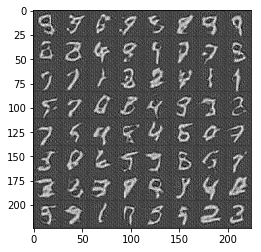

Epoch 1/2... Discriminator loss: 0.5701... Generator loss: 1.3941
Epoch 1/2... Discriminator loss: 0.7667... Generator loss: 2.6819
Epoch 1/2... Discriminator loss: 0.6314... Generator loss: 2.2034
Epoch 1/2... Discriminator loss: 0.4951... Generator loss: 1.4256
Epoch 1/2... Discriminator loss: 0.6208... Generator loss: 1.0763
Epoch 1/2... Discriminator loss: 0.1723... Generator loss: 3.1161
Epoch 1/2... Discriminator loss: 0.2462... Generator loss: 2.2638
Epoch 1/2... Discriminator loss: 0.1350... Generator loss: 2.6817
Epoch 1/2... Discriminator loss: 0.1485... Generator loss: 2.4311
Epoch 1/2... Discriminator loss: 0.0441... Generator loss: 3.9917


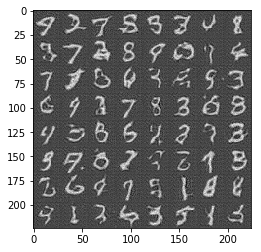

Epoch 1/2... Discriminator loss: 0.0279... Generator loss: 5.3938
Epoch 1/2... Discriminator loss: 0.1604... Generator loss: 2.5631
Epoch 1/2... Discriminator loss: 0.4879... Generator loss: 1.2132
Epoch 1/2... Discriminator loss: 1.9235... Generator loss: 4.0091
Epoch 1/2... Discriminator loss: 2.5560... Generator loss: 0.1673
Epoch 1/2... Discriminator loss: 0.3132... Generator loss: 2.0251
Epoch 1/2... Discriminator loss: 0.4865... Generator loss: 1.2786
Epoch 1/2... Discriminator loss: 0.3429... Generator loss: 1.6884
Epoch 1/2... Discriminator loss: 0.0197... Generator loss: 6.1530
Epoch 1/2... Discriminator loss: 0.0685... Generator loss: 5.5693


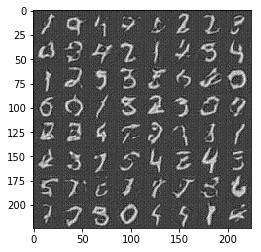

Epoch 1/2... Discriminator loss: 0.8426... Generator loss: 0.8301
Epoch 1/2... Discriminator loss: 0.1408... Generator loss: 2.5373
Epoch 1/2... Discriminator loss: 0.4737... Generator loss: 1.3194
Epoch 1/2... Discriminator loss: 0.0628... Generator loss: 3.5219
Epoch 1/2... Discriminator loss: 0.5062... Generator loss: 1.3118
Epoch 1/2... Discriminator loss: 1.7227... Generator loss: 0.4777
Epoch 1/2... Discriminator loss: 0.4811... Generator loss: 1.5092
Epoch 1/2... Discriminator loss: 0.3475... Generator loss: 2.3968
Epoch 1/2... Discriminator loss: 2.9274... Generator loss: 0.1162
Epoch 1/2... Discriminator loss: 1.3266... Generator loss: 0.4578


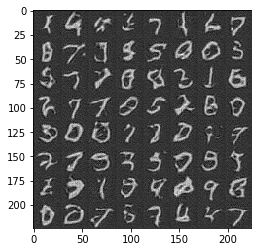

Epoch 1/2... Discriminator loss: 1.0125... Generator loss: 0.7623
Epoch 1/2... Discriminator loss: 0.2393... Generator loss: 2.1590
Epoch 1/2... Discriminator loss: 0.1953... Generator loss: 2.7765
Epoch 1/2... Discriminator loss: 0.0817... Generator loss: 3.4498
Epoch 1/2... Discriminator loss: 0.2172... Generator loss: 2.2831


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator loss: 0.4889... Generator loss: 1.6542
Epoch 0/1... Discriminator loss: 2.7208... Generator loss: 0.1376
Epoch 0/1... Discriminator loss: 1.0549... Generator loss: 0.7744
Epoch 0/1... Discriminator loss: 0.2882... Generator loss: 2.6970
Epoch 0/1... Discriminator loss: 0.6525... Generator loss: 5.0444
Epoch 0/1... Discriminator loss: 0.0972... Generator loss: 2.7941
Epoch 0/1... Discriminator loss: 0.0280... Generator loss: 4.8205
Epoch 0/1... Discriminator loss: 0.0558... Generator loss: 3.3870
Epoch 0/1... Discriminator loss: 0.0529... Generator loss: 3.4534
Epoch 0/1... Discriminator loss: 0.0105... Generator loss: 5.2669


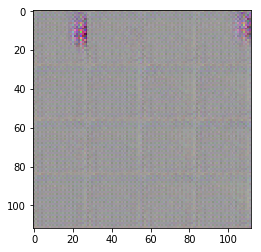

Epoch 0/1... Discriminator loss: 0.0414... Generator loss: 3.9981
Epoch 0/1... Discriminator loss: 0.0257... Generator loss: 4.4668
Epoch 0/1... Discriminator loss: 0.0032... Generator loss: 6.5766
Epoch 0/1... Discriminator loss: 0.0058... Generator loss: 5.7127
Epoch 0/1... Discriminator loss: 0.0034... Generator loss: 7.1190
Epoch 0/1... Discriminator loss: 0.0028... Generator loss: 6.5742
Epoch 0/1... Discriminator loss: 0.0023... Generator loss: 6.9490
Epoch 0/1... Discriminator loss: 0.0040... Generator loss: 6.3922
Epoch 0/1... Discriminator loss: 0.0015... Generator loss: 7.5050
Epoch 0/1... Discriminator loss: 0.0854... Generator loss: 2.9863


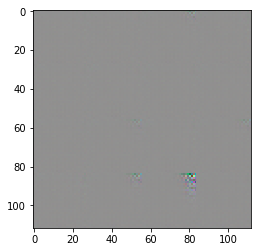

Epoch 0/1... Discriminator loss: 0.0043... Generator loss: 7.2135
Epoch 0/1... Discriminator loss: 0.7544... Generator loss: 1.7095
Epoch 0/1... Discriminator loss: 2.0328... Generator loss: 0.8405
Epoch 0/1... Discriminator loss: 0.7153... Generator loss: 1.0222
Epoch 0/1... Discriminator loss: 0.2378... Generator loss: 2.5557
Epoch 0/1... Discriminator loss: 0.0701... Generator loss: 4.2865
Epoch 0/1... Discriminator loss: 0.4533... Generator loss: 1.9513
Epoch 0/1... Discriminator loss: 2.8314... Generator loss: 11.0072
Epoch 0/1... Discriminator loss: 0.0145... Generator loss: 4.6997
Epoch 0/1... Discriminator loss: 0.6857... Generator loss: 4.2497


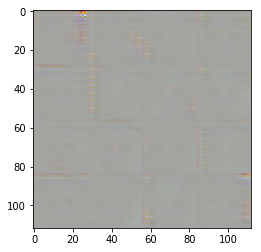

Epoch 0/1... Discriminator loss: 0.9953... Generator loss: 0.6385
Epoch 0/1... Discriminator loss: 1.4784... Generator loss: 0.3080
Epoch 0/1... Discriminator loss: 0.5037... Generator loss: 1.2278
Epoch 0/1... Discriminator loss: 0.1129... Generator loss: 4.4621
Epoch 0/1... Discriminator loss: 0.1304... Generator loss: 3.1551
Epoch 0/1... Discriminator loss: 0.0913... Generator loss: 3.7217
Epoch 0/1... Discriminator loss: 0.4073... Generator loss: 9.1689
Epoch 0/1... Discriminator loss: 0.1002... Generator loss: 3.3365
Epoch 0/1... Discriminator loss: 0.1322... Generator loss: 2.7828
Epoch 0/1... Discriminator loss: 3.5442... Generator loss: 3.7482


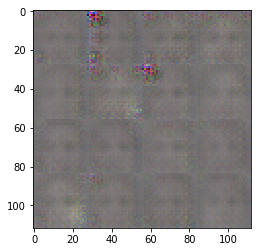

Epoch 0/1... Discriminator loss: 0.2463... Generator loss: 5.7386
Epoch 0/1... Discriminator loss: 0.2435... Generator loss: 7.7663
Epoch 0/1... Discriminator loss: 1.5808... Generator loss: 0.3331
Epoch 0/1... Discriminator loss: 0.1278... Generator loss: 3.0172
Epoch 0/1... Discriminator loss: 0.3665... Generator loss: 1.7652
Epoch 0/1... Discriminator loss: 0.2088... Generator loss: 4.2732
Epoch 0/1... Discriminator loss: 0.0990... Generator loss: 5.0351
Epoch 0/1... Discriminator loss: 0.0236... Generator loss: 7.8995
Epoch 0/1... Discriminator loss: 0.0301... Generator loss: 7.6809
Epoch 0/1... Discriminator loss: 0.0357... Generator loss: 6.8891


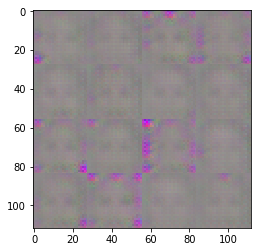

Epoch 0/1... Discriminator loss: 2.4604... Generator loss: 8.9306
Epoch 0/1... Discriminator loss: 1.6455... Generator loss: 0.4390
Epoch 0/1... Discriminator loss: 0.3035... Generator loss: 4.5737
Epoch 0/1... Discriminator loss: 0.1134... Generator loss: 3.4341
Epoch 0/1... Discriminator loss: 1.8194... Generator loss: 5.9354
Epoch 0/1... Discriminator loss: 0.0794... Generator loss: 4.1535
Epoch 0/1... Discriminator loss: 0.5875... Generator loss: 1.4589
Epoch 0/1... Discriminator loss: 0.1652... Generator loss: 4.6104
Epoch 0/1... Discriminator loss: 0.0266... Generator loss: 6.6373
Epoch 0/1... Discriminator loss: 2.1513... Generator loss: 1.5921


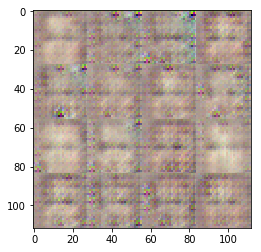

Epoch 0/1... Discriminator loss: 0.9045... Generator loss: 1.7141
Epoch 0/1... Discriminator loss: 0.3026... Generator loss: 4.4531
Epoch 0/1... Discriminator loss: 3.5428... Generator loss: 0.0384
Epoch 0/1... Discriminator loss: 1.6220... Generator loss: 0.4814
Epoch 0/1... Discriminator loss: 1.5987... Generator loss: 0.3773
Epoch 0/1... Discriminator loss: 1.0871... Generator loss: 0.8554
Epoch 0/1... Discriminator loss: 1.4870... Generator loss: 0.7903
Epoch 0/1... Discriminator loss: 1.9935... Generator loss: 0.4570
Epoch 0/1... Discriminator loss: 2.0571... Generator loss: 0.3678
Epoch 0/1... Discriminator loss: 1.1869... Generator loss: 0.7075


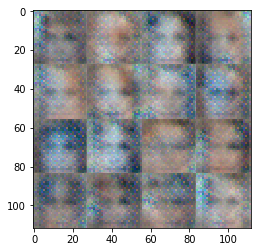

Epoch 0/1... Discriminator loss: 1.0922... Generator loss: 0.7894
Epoch 0/1... Discriminator loss: 1.7806... Generator loss: 0.3989
Epoch 0/1... Discriminator loss: 1.4951... Generator loss: 0.8904
Epoch 0/1... Discriminator loss: 1.4303... Generator loss: 0.6440
Epoch 0/1... Discriminator loss: 1.4048... Generator loss: 0.9487
Epoch 0/1... Discriminator loss: 1.4942... Generator loss: 0.5805
Epoch 0/1... Discriminator loss: 1.4281... Generator loss: 0.5912
Epoch 0/1... Discriminator loss: 1.5553... Generator loss: 1.1283
Epoch 0/1... Discriminator loss: 1.2326... Generator loss: 0.8070
Epoch 0/1... Discriminator loss: 1.3087... Generator loss: 0.6433


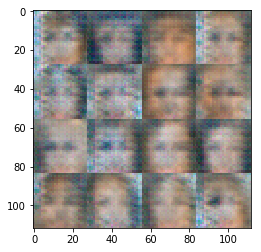

Epoch 0/1... Discriminator loss: 1.3397... Generator loss: 0.7517
Epoch 0/1... Discriminator loss: 1.2173... Generator loss: 0.9116
Epoch 0/1... Discriminator loss: 1.3426... Generator loss: 0.6213
Epoch 0/1... Discriminator loss: 1.5650... Generator loss: 0.6714
Epoch 0/1... Discriminator loss: 1.2160... Generator loss: 0.7251
Epoch 0/1... Discriminator loss: 1.4489... Generator loss: 0.5324
Epoch 0/1... Discriminator loss: 1.4134... Generator loss: 0.9626
Epoch 0/1... Discriminator loss: 1.7767... Generator loss: 0.7982
Epoch 0/1... Discriminator loss: 1.5013... Generator loss: 0.4468
Epoch 0/1... Discriminator loss: 1.3712... Generator loss: 0.6638


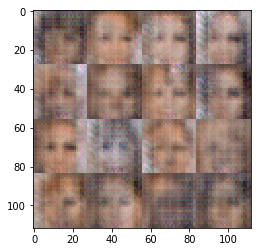

Epoch 0/1... Discriminator loss: 1.3722... Generator loss: 0.8530
Epoch 0/1... Discriminator loss: 1.5582... Generator loss: 0.6081
Epoch 0/1... Discriminator loss: 1.1971... Generator loss: 0.6689
Epoch 0/1... Discriminator loss: 1.4058... Generator loss: 0.7443
Epoch 0/1... Discriminator loss: 1.3530... Generator loss: 0.4980
Epoch 0/1... Discriminator loss: 1.4766... Generator loss: 0.4973
Epoch 0/1... Discriminator loss: 1.4455... Generator loss: 0.8559
Epoch 0/1... Discriminator loss: 1.5055... Generator loss: 0.5223
Epoch 0/1... Discriminator loss: 1.2771... Generator loss: 0.6287
Epoch 0/1... Discriminator loss: 1.2106... Generator loss: 0.6948


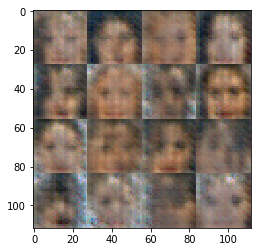

Epoch 0/1... Discriminator loss: 1.8359... Generator loss: 0.6452
Epoch 0/1... Discriminator loss: 1.1443... Generator loss: 0.7399
Epoch 0/1... Discriminator loss: 1.5671... Generator loss: 0.7204
Epoch 0/1... Discriminator loss: 1.4330... Generator loss: 0.6554
Epoch 0/1... Discriminator loss: 1.1704... Generator loss: 0.7598
Epoch 0/1... Discriminator loss: 1.5279... Generator loss: 0.5892
Epoch 0/1... Discriminator loss: 1.5275... Generator loss: 0.7089
Epoch 0/1... Discriminator loss: 1.1998... Generator loss: 0.8500
Epoch 0/1... Discriminator loss: 1.5491... Generator loss: 0.6774
Epoch 0/1... Discriminator loss: 1.5646... Generator loss: 0.5654


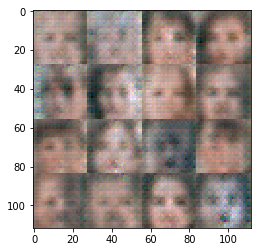

Epoch 0/1... Discriminator loss: 1.4505... Generator loss: 0.5454
Epoch 0/1... Discriminator loss: 1.3240... Generator loss: 0.7849
Epoch 0/1... Discriminator loss: 1.4210... Generator loss: 0.6005
Epoch 0/1... Discriminator loss: 1.3291... Generator loss: 0.7085
Epoch 0/1... Discriminator loss: 1.2101... Generator loss: 0.8597
Epoch 0/1... Discriminator loss: 1.6253... Generator loss: 0.5809
Epoch 0/1... Discriminator loss: 1.6508... Generator loss: 1.2308
Epoch 0/1... Discriminator loss: 1.2123... Generator loss: 0.7392
Epoch 0/1... Discriminator loss: 1.2754... Generator loss: 0.7222
Epoch 0/1... Discriminator loss: 1.4719... Generator loss: 0.8339


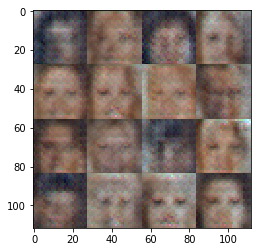

Epoch 0/1... Discriminator loss: 1.2158... Generator loss: 0.7163
Epoch 0/1... Discriminator loss: 1.3035... Generator loss: 0.6664
Epoch 0/1... Discriminator loss: 1.3287... Generator loss: 1.0917
Epoch 0/1... Discriminator loss: 1.4349... Generator loss: 0.6188
Epoch 0/1... Discriminator loss: 1.3792... Generator loss: 0.9817
Epoch 0/1... Discriminator loss: 1.3291... Generator loss: 0.7467
Epoch 0/1... Discriminator loss: 1.2042... Generator loss: 0.6077
Epoch 0/1... Discriminator loss: 1.2371... Generator loss: 0.7367
Epoch 0/1... Discriminator loss: 1.2765... Generator loss: 0.6395
Epoch 0/1... Discriminator loss: 1.2052... Generator loss: 0.9891


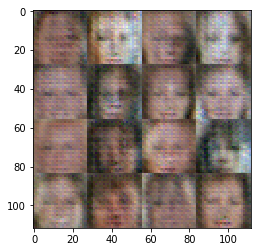

Epoch 0/1... Discriminator loss: 1.3451... Generator loss: 0.6735
Epoch 0/1... Discriminator loss: 1.3690... Generator loss: 0.6318
Epoch 0/1... Discriminator loss: 1.7691... Generator loss: 0.5527
Epoch 0/1... Discriminator loss: 1.5137... Generator loss: 0.4747
Epoch 0/1... Discriminator loss: 1.1309... Generator loss: 0.6765
Epoch 0/1... Discriminator loss: 1.2556... Generator loss: 0.7674
Epoch 0/1... Discriminator loss: 1.1000... Generator loss: 0.8116
Epoch 0/1... Discriminator loss: 1.2608... Generator loss: 0.7450
Epoch 0/1... Discriminator loss: 1.1691... Generator loss: 0.8785
Epoch 0/1... Discriminator loss: 1.6651... Generator loss: 0.4877


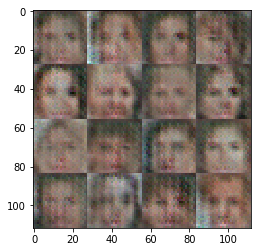

Epoch 0/1... Discriminator loss: 1.3725... Generator loss: 0.8730
Epoch 0/1... Discriminator loss: 1.2917... Generator loss: 0.8724
Epoch 0/1... Discriminator loss: 1.2157... Generator loss: 0.7257
Epoch 0/1... Discriminator loss: 1.6353... Generator loss: 0.4848
Epoch 0/1... Discriminator loss: 1.2618... Generator loss: 0.6979
Epoch 0/1... Discriminator loss: 1.2577... Generator loss: 0.7502
Epoch 0/1... Discriminator loss: 1.2114... Generator loss: 0.8722
Epoch 0/1... Discriminator loss: 1.5457... Generator loss: 0.5571
Epoch 0/1... Discriminator loss: 1.3355... Generator loss: 0.7147
Epoch 0/1... Discriminator loss: 1.4006... Generator loss: 0.8938


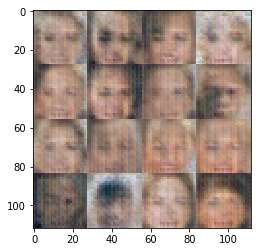

Epoch 0/1... Discriminator loss: 1.3195... Generator loss: 0.7098
Epoch 0/1... Discriminator loss: 1.5689... Generator loss: 0.5631
Epoch 0/1... Discriminator loss: 1.4593... Generator loss: 1.2191
Epoch 0/1... Discriminator loss: 1.4570... Generator loss: 0.5308
Epoch 0/1... Discriminator loss: 1.3675... Generator loss: 0.7064
Epoch 0/1... Discriminator loss: 1.3380... Generator loss: 0.6137
Epoch 0/1... Discriminator loss: 1.1877... Generator loss: 1.0563
Epoch 0/1... Discriminator loss: 1.7026... Generator loss: 0.4226
Epoch 0/1... Discriminator loss: 1.1016... Generator loss: 0.9020
Epoch 0/1... Discriminator loss: 1.5374... Generator loss: 0.5918


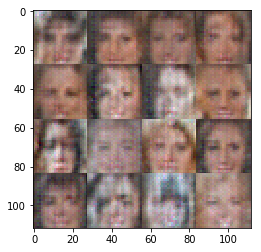

Epoch 0/1... Discriminator loss: 1.5390... Generator loss: 0.6990
Epoch 0/1... Discriminator loss: 1.2242... Generator loss: 0.8091
Epoch 0/1... Discriminator loss: 1.4471... Generator loss: 0.6069
Epoch 0/1... Discriminator loss: 1.2210... Generator loss: 0.7447
Epoch 0/1... Discriminator loss: 1.4036... Generator loss: 0.7617
Epoch 0/1... Discriminator loss: 1.3494... Generator loss: 0.6074
Epoch 0/1... Discriminator loss: 1.3005... Generator loss: 0.7836
Epoch 0/1... Discriminator loss: 1.3599... Generator loss: 0.6643
Epoch 0/1... Discriminator loss: 1.5702... Generator loss: 0.5622
Epoch 0/1... Discriminator loss: 1.3451... Generator loss: 0.6844


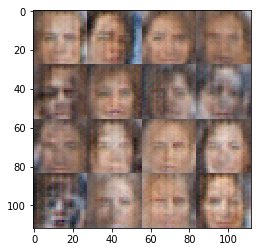

Epoch 0/1... Discriminator loss: 1.3839... Generator loss: 0.6831
Epoch 0/1... Discriminator loss: 1.3309... Generator loss: 0.6903
Epoch 0/1... Discriminator loss: 1.3680... Generator loss: 0.5826
Epoch 0/1... Discriminator loss: 1.3714... Generator loss: 0.6869
Epoch 0/1... Discriminator loss: 1.3123... Generator loss: 0.7405
Epoch 0/1... Discriminator loss: 1.4385... Generator loss: 0.6448
Epoch 0/1... Discriminator loss: 1.2273... Generator loss: 0.7582
Epoch 0/1... Discriminator loss: 1.3727... Generator loss: 0.7657
Epoch 0/1... Discriminator loss: 1.4758... Generator loss: 0.9458
Epoch 0/1... Discriminator loss: 1.2088... Generator loss: 0.8095


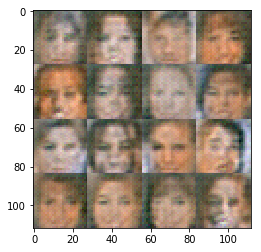

Epoch 0/1... Discriminator loss: 1.1458... Generator loss: 0.8210
Epoch 0/1... Discriminator loss: 1.3485... Generator loss: 0.6573
Epoch 0/1... Discriminator loss: 1.4231... Generator loss: 0.5736
Epoch 0/1... Discriminator loss: 1.3791... Generator loss: 0.6533
Epoch 0/1... Discriminator loss: 1.2332... Generator loss: 0.8942
Epoch 0/1... Discriminator loss: 1.4590... Generator loss: 0.7345
Epoch 0/1... Discriminator loss: 1.4234... Generator loss: 0.8227
Epoch 0/1... Discriminator loss: 1.2973... Generator loss: 0.6113
Epoch 0/1... Discriminator loss: 1.3592... Generator loss: 0.5218
Epoch 0/1... Discriminator loss: 1.2377... Generator loss: 0.5994


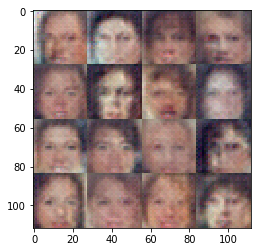

Epoch 0/1... Discriminator loss: 1.2725... Generator loss: 0.7742
Epoch 0/1... Discriminator loss: 1.2492... Generator loss: 0.8699
Epoch 0/1... Discriminator loss: 1.3599... Generator loss: 0.5450
Epoch 0/1... Discriminator loss: 1.3554... Generator loss: 0.7054
Epoch 0/1... Discriminator loss: 1.4069... Generator loss: 0.6434
Epoch 0/1... Discriminator loss: 1.3487... Generator loss: 0.6793
Epoch 0/1... Discriminator loss: 1.2719... Generator loss: 0.9369
Epoch 0/1... Discriminator loss: 1.3820... Generator loss: 0.8141
Epoch 0/1... Discriminator loss: 1.3104... Generator loss: 0.6233
Epoch 0/1... Discriminator loss: 1.4405... Generator loss: 0.5532


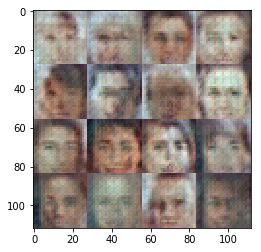

Epoch 0/1... Discriminator loss: 1.3038... Generator loss: 0.7686
Epoch 0/1... Discriminator loss: 1.3192... Generator loss: 0.9351
Epoch 0/1... Discriminator loss: 1.2099... Generator loss: 0.7600
Epoch 0/1... Discriminator loss: 1.2165... Generator loss: 0.8703
Epoch 0/1... Discriminator loss: 1.3776... Generator loss: 0.5261
Epoch 0/1... Discriminator loss: 1.4519... Generator loss: 0.5663
Epoch 0/1... Discriminator loss: 1.4258... Generator loss: 0.6483
Epoch 0/1... Discriminator loss: 1.3588... Generator loss: 0.6229
Epoch 0/1... Discriminator loss: 1.3644... Generator loss: 0.5186
Epoch 0/1... Discriminator loss: 1.3021... Generator loss: 0.5353


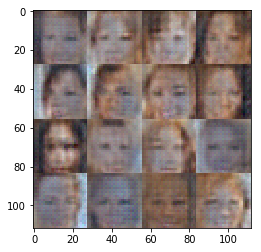

Epoch 0/1... Discriminator loss: 1.2532... Generator loss: 0.7606
Epoch 0/1... Discriminator loss: 1.6320... Generator loss: 0.4073
Epoch 0/1... Discriminator loss: 1.3943... Generator loss: 0.8367
Epoch 0/1... Discriminator loss: 1.3076... Generator loss: 0.8205
Epoch 0/1... Discriminator loss: 1.3663... Generator loss: 0.7564
Epoch 0/1... Discriminator loss: 1.3757... Generator loss: 0.4913
Epoch 0/1... Discriminator loss: 1.3863... Generator loss: 0.6196
Epoch 0/1... Discriminator loss: 1.4596... Generator loss: 0.7812
Epoch 0/1... Discriminator loss: 1.2811... Generator loss: 0.8424
Epoch 0/1... Discriminator loss: 1.4889... Generator loss: 0.6074


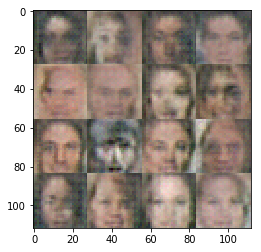

Epoch 0/1... Discriminator loss: 1.3072... Generator loss: 0.8040
Epoch 0/1... Discriminator loss: 1.2203... Generator loss: 0.6540
Epoch 0/1... Discriminator loss: 1.4948... Generator loss: 0.5945
Epoch 0/1... Discriminator loss: 1.3202... Generator loss: 0.6736
Epoch 0/1... Discriminator loss: 1.4494... Generator loss: 0.8691
Epoch 0/1... Discriminator loss: 1.1861... Generator loss: 0.6688
Epoch 0/1... Discriminator loss: 1.3763... Generator loss: 0.7655
Epoch 0/1... Discriminator loss: 1.3056... Generator loss: 0.7075
Epoch 0/1... Discriminator loss: 1.3645... Generator loss: 0.7077
Epoch 0/1... Discriminator loss: 1.3056... Generator loss: 0.5780


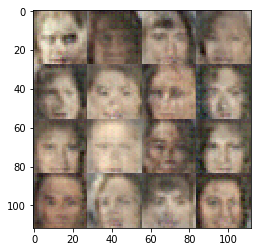

Epoch 0/1... Discriminator loss: 1.2194... Generator loss: 0.7804
Epoch 0/1... Discriminator loss: 1.3781... Generator loss: 0.6804
Epoch 0/1... Discriminator loss: 1.5684... Generator loss: 0.5218
Epoch 0/1... Discriminator loss: 1.3297... Generator loss: 0.5965
Epoch 0/1... Discriminator loss: 1.4400... Generator loss: 0.6405
Epoch 0/1... Discriminator loss: 1.3329... Generator loss: 0.7009
Epoch 0/1... Discriminator loss: 1.5060... Generator loss: 0.6196
Epoch 0/1... Discriminator loss: 1.4248... Generator loss: 0.6391
Epoch 0/1... Discriminator loss: 1.2083... Generator loss: 0.7033
Epoch 0/1... Discriminator loss: 1.2371... Generator loss: 0.7404


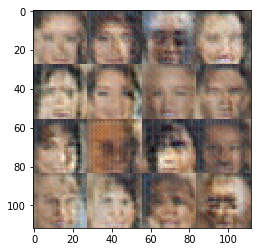

Epoch 0/1... Discriminator loss: 1.3086... Generator loss: 0.6848
Epoch 0/1... Discriminator loss: 1.4154... Generator loss: 0.5520
Epoch 0/1... Discriminator loss: 1.4684... Generator loss: 0.8365
Epoch 0/1... Discriminator loss: 1.3827... Generator loss: 0.5290
Epoch 0/1... Discriminator loss: 1.5220... Generator loss: 0.5502
Epoch 0/1... Discriminator loss: 1.6289... Generator loss: 0.6005
Epoch 0/1... Discriminator loss: 1.5356... Generator loss: 0.4177
Epoch 0/1... Discriminator loss: 1.2621... Generator loss: 0.6005
Epoch 0/1... Discriminator loss: 1.4953... Generator loss: 0.5017
Epoch 0/1... Discriminator loss: 0.9840... Generator loss: 1.0846


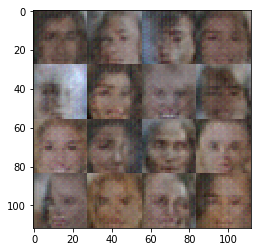

Epoch 0/1... Discriminator loss: 1.3440... Generator loss: 0.6184
Epoch 0/1... Discriminator loss: 1.3372... Generator loss: 0.6397
Epoch 0/1... Discriminator loss: 1.3501... Generator loss: 0.4985
Epoch 0/1... Discriminator loss: 1.4764... Generator loss: 0.6794
Epoch 0/1... Discriminator loss: 1.4189... Generator loss: 0.6766
Epoch 0/1... Discriminator loss: 1.4146... Generator loss: 0.6873
Epoch 0/1... Discriminator loss: 1.3295... Generator loss: 0.5713
Epoch 0/1... Discriminator loss: 1.2961... Generator loss: 0.7752
Epoch 0/1... Discriminator loss: 1.1290... Generator loss: 0.8824
Epoch 0/1... Discriminator loss: 1.3279... Generator loss: 0.5932


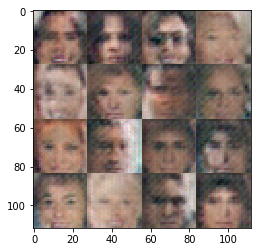

Epoch 0/1... Discriminator loss: 1.4520... Generator loss: 0.6912
Epoch 0/1... Discriminator loss: 1.5417... Generator loss: 0.5159
Epoch 0/1... Discriminator loss: 1.2954... Generator loss: 0.7395
Epoch 0/1... Discriminator loss: 1.3445... Generator loss: 0.5931
Epoch 0/1... Discriminator loss: 1.1831... Generator loss: 1.0098
Epoch 0/1... Discriminator loss: 1.3266... Generator loss: 0.5892
Epoch 0/1... Discriminator loss: 1.4442... Generator loss: 0.6975
Epoch 0/1... Discriminator loss: 1.4923... Generator loss: 0.5020
Epoch 0/1... Discriminator loss: 1.3333... Generator loss: 0.7637
Epoch 0/1... Discriminator loss: 1.5163... Generator loss: 0.6795


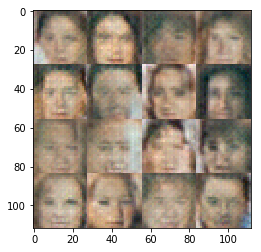

Epoch 0/1... Discriminator loss: 1.3389... Generator loss: 0.6199
Epoch 0/1... Discriminator loss: 1.4075... Generator loss: 0.6863
Epoch 0/1... Discriminator loss: 1.4185... Generator loss: 0.7076
Epoch 0/1... Discriminator loss: 1.4194... Generator loss: 0.5484
Epoch 0/1... Discriminator loss: 1.5002... Generator loss: 0.5262
Epoch 0/1... Discriminator loss: 1.3423... Generator loss: 0.8095
Epoch 0/1... Discriminator loss: 1.3200... Generator loss: 0.7194
Epoch 0/1... Discriminator loss: 1.4868... Generator loss: 0.5098
Epoch 0/1... Discriminator loss: 1.4469... Generator loss: 0.5996
Epoch 0/1... Discriminator loss: 1.3514... Generator loss: 0.7323


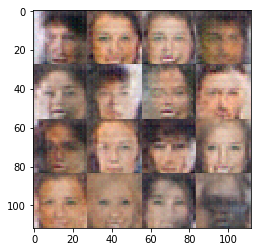

Epoch 0/1... Discriminator loss: 1.6227... Generator loss: 0.4769
Epoch 0/1... Discriminator loss: 1.4767... Generator loss: 0.6088
Epoch 0/1... Discriminator loss: 1.5443... Generator loss: 0.6319
Epoch 0/1... Discriminator loss: 1.4196... Generator loss: 0.7075
Epoch 0/1... Discriminator loss: 1.4137... Generator loss: 0.6658
Epoch 0/1... Discriminator loss: 1.3014... Generator loss: 0.6855
Epoch 0/1... Discriminator loss: 1.3799... Generator loss: 0.7026
Epoch 0/1... Discriminator loss: 1.3796... Generator loss: 0.5860
Epoch 0/1... Discriminator loss: 1.4350... Generator loss: 0.6200
Epoch 0/1... Discriminator loss: 1.3083... Generator loss: 0.6530


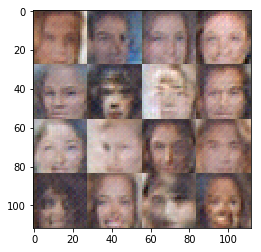

Epoch 0/1... Discriminator loss: 1.4526... Generator loss: 0.6148
Epoch 0/1... Discriminator loss: 1.2993... Generator loss: 0.7541
Epoch 0/1... Discriminator loss: 1.1788... Generator loss: 0.6706
Epoch 0/1... Discriminator loss: 1.3926... Generator loss: 0.6769
Epoch 0/1... Discriminator loss: 1.4350... Generator loss: 0.7355
Epoch 0/1... Discriminator loss: 1.3696... Generator loss: 0.5387
Epoch 0/1... Discriminator loss: 1.4507... Generator loss: 0.8102
Epoch 0/1... Discriminator loss: 1.4230... Generator loss: 0.6471
Epoch 0/1... Discriminator loss: 1.5153... Generator loss: 0.4773
Epoch 0/1... Discriminator loss: 1.3393... Generator loss: 0.7369


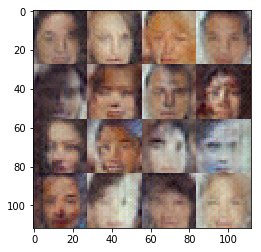

Epoch 0/1... Discriminator loss: 1.4568... Generator loss: 0.6798
Epoch 0/1... Discriminator loss: 1.4076... Generator loss: 0.6261
Epoch 0/1... Discriminator loss: 1.3450... Generator loss: 0.6274
Epoch 0/1... Discriminator loss: 1.3170... Generator loss: 0.6813
Epoch 0/1... Discriminator loss: 1.2988... Generator loss: 0.6659
Epoch 0/1... Discriminator loss: 1.3821... Generator loss: 0.6606
Epoch 0/1... Discriminator loss: 1.3004... Generator loss: 0.7276
Epoch 0/1... Discriminator loss: 1.2488... Generator loss: 0.7758
Epoch 0/1... Discriminator loss: 1.3435... Generator loss: 0.7150
Epoch 0/1... Discriminator loss: 1.2873... Generator loss: 0.7012


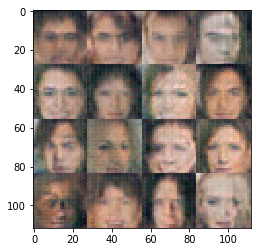

Epoch 0/1... Discriminator loss: 1.1815... Generator loss: 0.7543
Epoch 0/1... Discriminator loss: 1.3412... Generator loss: 0.6854
Epoch 0/1... Discriminator loss: 1.4650... Generator loss: 0.4995
Epoch 0/1... Discriminator loss: 1.4840... Generator loss: 0.6012
Epoch 0/1... Discriminator loss: 1.4119... Generator loss: 0.6412
Epoch 0/1... Discriminator loss: 1.3563... Generator loss: 0.5794
Epoch 0/1... Discriminator loss: 1.3472... Generator loss: 0.6380
Epoch 0/1... Discriminator loss: 1.4031... Generator loss: 0.6625
Epoch 0/1... Discriminator loss: 1.4804... Generator loss: 0.5249
Epoch 0/1... Discriminator loss: 1.4757... Generator loss: 0.5764


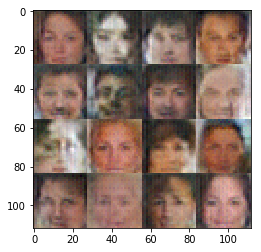

Epoch 0/1... Discriminator loss: 1.3237... Generator loss: 0.7235
Epoch 0/1... Discriminator loss: 1.3629... Generator loss: 0.7256
Epoch 0/1... Discriminator loss: 1.2811... Generator loss: 0.7199
Epoch 0/1... Discriminator loss: 1.4053... Generator loss: 0.5038
Epoch 0/1... Discriminator loss: 1.2244... Generator loss: 0.6673
Epoch 0/1... Discriminator loss: 1.4289... Generator loss: 0.6287
Epoch 0/1... Discriminator loss: 1.2958... Generator loss: 0.7181
Epoch 0/1... Discriminator loss: 1.2741... Generator loss: 0.6615
Epoch 0/1... Discriminator loss: 1.4416... Generator loss: 0.5472
Epoch 0/1... Discriminator loss: 1.3990... Generator loss: 0.7081


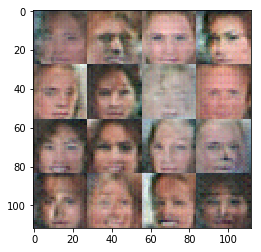

Epoch 0/1... Discriminator loss: 1.4164... Generator loss: 0.6044
Epoch 0/1... Discriminator loss: 1.2719... Generator loss: 0.7839
Epoch 0/1... Discriminator loss: 1.5133... Generator loss: 0.5942
Epoch 0/1... Discriminator loss: 1.4430... Generator loss: 0.5857
Epoch 0/1... Discriminator loss: 1.3762... Generator loss: 0.6851
Epoch 0/1... Discriminator loss: 1.4063... Generator loss: 0.5985
Epoch 0/1... Discriminator loss: 1.4133... Generator loss: 0.6573
Epoch 0/1... Discriminator loss: 1.2485... Generator loss: 0.7958
Epoch 0/1... Discriminator loss: 1.3686... Generator loss: 0.7387
Epoch 0/1... Discriminator loss: 1.4209... Generator loss: 0.5976


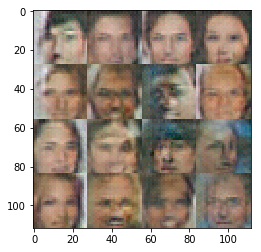

Epoch 0/1... Discriminator loss: 1.3500... Generator loss: 0.7133
Epoch 0/1... Discriminator loss: 1.4052... Generator loss: 0.5861
Epoch 0/1... Discriminator loss: 1.3412... Generator loss: 0.7296
Epoch 0/1... Discriminator loss: 1.4901... Generator loss: 0.6394
Epoch 0/1... Discriminator loss: 1.4194... Generator loss: 0.7055
Epoch 0/1... Discriminator loss: 1.3989... Generator loss: 0.6859
Epoch 0/1... Discriminator loss: 1.3492... Generator loss: 0.5650
Epoch 0/1... Discriminator loss: 1.3534... Generator loss: 0.5634
Epoch 0/1... Discriminator loss: 1.4860... Generator loss: 0.6340
Epoch 0/1... Discriminator loss: 1.3690... Generator loss: 0.5729


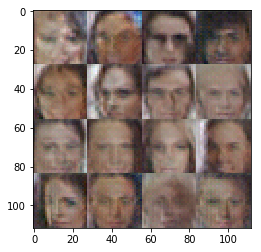

Epoch 0/1... Discriminator loss: 1.3324... Generator loss: 0.7378
Epoch 0/1... Discriminator loss: 1.2678... Generator loss: 0.6956
Epoch 0/1... Discriminator loss: 1.4478... Generator loss: 0.6547
Epoch 0/1... Discriminator loss: 1.3260... Generator loss: 0.6279
Epoch 0/1... Discriminator loss: 1.4287... Generator loss: 0.6012
Epoch 0/1... Discriminator loss: 1.4629... Generator loss: 0.5367
Epoch 0/1... Discriminator loss: 1.4106... Generator loss: 0.6386
Epoch 0/1... Discriminator loss: 1.3977... Generator loss: 0.7621
Epoch 0/1... Discriminator loss: 1.2960... Generator loss: 0.6110
Epoch 0/1... Discriminator loss: 1.3692... Generator loss: 0.7616


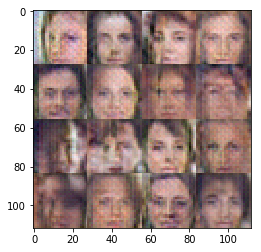

Epoch 0/1... Discriminator loss: 1.2310... Generator loss: 0.7732
Epoch 0/1... Discriminator loss: 1.4023... Generator loss: 0.6126
Epoch 0/1... Discriminator loss: 1.2490... Generator loss: 0.6921
Epoch 0/1... Discriminator loss: 1.3105... Generator loss: 0.7101
Epoch 0/1... Discriminator loss: 1.2644... Generator loss: 0.6809
Epoch 0/1... Discriminator loss: 1.4780... Generator loss: 0.5954
Epoch 0/1... Discriminator loss: 1.3301... Generator loss: 0.6271
Epoch 0/1... Discriminator loss: 1.3689... Generator loss: 0.6584
Epoch 0/1... Discriminator loss: 1.3267... Generator loss: 0.7087
Epoch 0/1... Discriminator loss: 1.3903... Generator loss: 0.6003


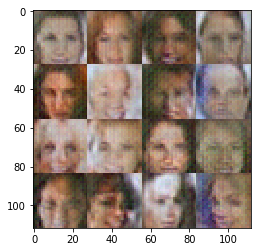

Epoch 0/1... Discriminator loss: 1.3683... Generator loss: 0.6505
Epoch 0/1... Discriminator loss: 1.4578... Generator loss: 0.6182
Epoch 0/1... Discriminator loss: 1.4391... Generator loss: 0.6555
Epoch 0/1... Discriminator loss: 1.3362... Generator loss: 0.7326
Epoch 0/1... Discriminator loss: 1.2415... Generator loss: 0.7649
Epoch 0/1... Discriminator loss: 1.3921... Generator loss: 0.6305
Epoch 0/1... Discriminator loss: 1.5039... Generator loss: 0.7159
Epoch 0/1... Discriminator loss: 1.2312... Generator loss: 0.7756
Epoch 0/1... Discriminator loss: 1.4807... Generator loss: 0.5712
Epoch 0/1... Discriminator loss: 1.5473... Generator loss: 0.7060


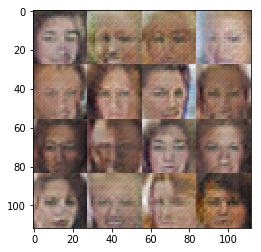

Epoch 0/1... Discriminator loss: 1.4981... Generator loss: 0.5880
Epoch 0/1... Discriminator loss: 1.3661... Generator loss: 0.6198
Epoch 0/1... Discriminator loss: 1.3841... Generator loss: 0.6793
Epoch 0/1... Discriminator loss: 1.4128... Generator loss: 0.7235
Epoch 0/1... Discriminator loss: 1.4592... Generator loss: 0.5848
Epoch 0/1... Discriminator loss: 1.2794... Generator loss: 0.7462
Epoch 0/1... Discriminator loss: 1.4269... Generator loss: 0.6012
Epoch 0/1... Discriminator loss: 1.3500... Generator loss: 0.6321
Epoch 0/1... Discriminator loss: 1.3854... Generator loss: 0.6502
Epoch 0/1... Discriminator loss: 1.3893... Generator loss: 0.5729


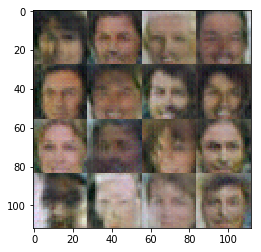

Epoch 0/1... Discriminator loss: 1.4451... Generator loss: 0.6489
Epoch 0/1... Discriminator loss: 1.4628... Generator loss: 0.5942
Epoch 0/1... Discriminator loss: 1.2621... Generator loss: 0.7601
Epoch 0/1... Discriminator loss: 1.3199... Generator loss: 0.6906
Epoch 0/1... Discriminator loss: 1.2837... Generator loss: 0.7118
Epoch 0/1... Discriminator loss: 1.4518... Generator loss: 0.5515
Epoch 0/1... Discriminator loss: 1.3865... Generator loss: 0.6498
Epoch 0/1... Discriminator loss: 1.4556... Generator loss: 0.5764
Epoch 0/1... Discriminator loss: 1.4178... Generator loss: 0.5705
Epoch 0/1... Discriminator loss: 1.3981... Generator loss: 0.5700


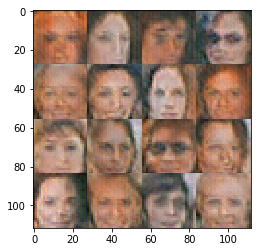

Epoch 0/1... Discriminator loss: 1.3145... Generator loss: 0.7134
Epoch 0/1... Discriminator loss: 1.4644... Generator loss: 0.6823
Epoch 0/1... Discriminator loss: 1.3352... Generator loss: 0.5968
Epoch 0/1... Discriminator loss: 1.3560... Generator loss: 0.6854
Epoch 0/1... Discriminator loss: 1.2439... Generator loss: 0.8346
Epoch 0/1... Discriminator loss: 1.3496... Generator loss: 0.6500
Epoch 0/1... Discriminator loss: 1.4017... Generator loss: 0.6848
Epoch 0/1... Discriminator loss: 1.4276... Generator loss: 0.6706
Epoch 0/1... Discriminator loss: 1.3775... Generator loss: 0.6601
Epoch 0/1... Discriminator loss: 1.3277... Generator loss: 0.7268


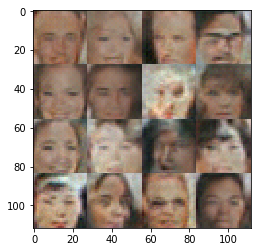

Epoch 0/1... Discriminator loss: 1.3626... Generator loss: 0.6556
Epoch 0/1... Discriminator loss: 1.3145... Generator loss: 0.6772
Epoch 0/1... Discriminator loss: 1.5777... Generator loss: 0.4705
Epoch 0/1... Discriminator loss: 1.4290... Generator loss: 0.5753
Epoch 0/1... Discriminator loss: 1.4667... Generator loss: 0.5338
Epoch 0/1... Discriminator loss: 1.4388... Generator loss: 0.6510
Epoch 0/1... Discriminator loss: 1.2306... Generator loss: 0.7627
Epoch 0/1... Discriminator loss: 1.3827... Generator loss: 0.6281
Epoch 0/1... Discriminator loss: 1.4460... Generator loss: 0.6537
Epoch 0/1... Discriminator loss: 1.3365... Generator loss: 0.6940


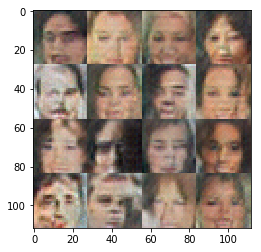

Epoch 0/1... Discriminator loss: 1.2994... Generator loss: 0.7387
Epoch 0/1... Discriminator loss: 1.2770... Generator loss: 0.7239
Epoch 0/1... Discriminator loss: 1.2603... Generator loss: 0.7286
Epoch 0/1... Discriminator loss: 1.3831... Generator loss: 0.8195
Epoch 0/1... Discriminator loss: 1.6489... Generator loss: 0.5208
Epoch 0/1... Discriminator loss: 1.3602... Generator loss: 0.7247
Epoch 0/1... Discriminator loss: 1.4431... Generator loss: 0.6607
Epoch 0/1... Discriminator loss: 1.3433... Generator loss: 0.6831
Epoch 0/1... Discriminator loss: 1.3174... Generator loss: 0.7585
Epoch 0/1... Discriminator loss: 1.3528... Generator loss: 0.6379


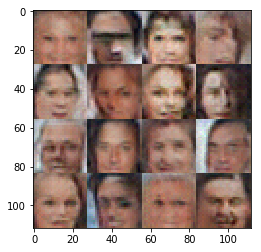

Epoch 0/1... Discriminator loss: 1.4797... Generator loss: 0.6225
Epoch 0/1... Discriminator loss: 1.4351... Generator loss: 0.6021
Epoch 0/1... Discriminator loss: 1.5017... Generator loss: 0.5179
Epoch 0/1... Discriminator loss: 1.3205... Generator loss: 0.7203
Epoch 0/1... Discriminator loss: 1.4517... Generator loss: 0.4992
Epoch 0/1... Discriminator loss: 1.2566... Generator loss: 0.7831
Epoch 0/1... Discriminator loss: 1.3112... Generator loss: 0.6269
Epoch 0/1... Discriminator loss: 1.4234... Generator loss: 0.6412
Epoch 0/1... Discriminator loss: 1.3379... Generator loss: 0.6463
Epoch 0/1... Discriminator loss: 1.3568... Generator loss: 0.7124


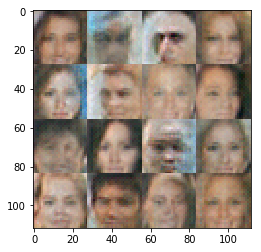

Epoch 0/1... Discriminator loss: 1.3827... Generator loss: 0.7204
Epoch 0/1... Discriminator loss: 1.3850... Generator loss: 0.5833
Epoch 0/1... Discriminator loss: 1.6407... Generator loss: 0.4700
Epoch 0/1... Discriminator loss: 1.4516... Generator loss: 0.5917
Epoch 0/1... Discriminator loss: 1.4415... Generator loss: 0.6457
Epoch 0/1... Discriminator loss: 1.4396... Generator loss: 0.6350
Epoch 0/1... Discriminator loss: 1.3381... Generator loss: 0.7056
Epoch 0/1... Discriminator loss: 1.2502... Generator loss: 0.8066
Epoch 0/1... Discriminator loss: 1.3852... Generator loss: 0.6383
Epoch 0/1... Discriminator loss: 1.4658... Generator loss: 0.4960


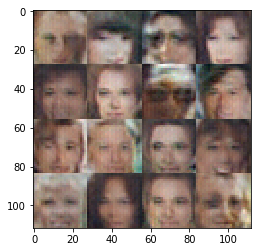

Epoch 0/1... Discriminator loss: 1.4351... Generator loss: 0.6513
Epoch 0/1... Discriminator loss: 1.4090... Generator loss: 0.6598
Epoch 0/1... Discriminator loss: 1.4493... Generator loss: 0.5943
Epoch 0/1... Discriminator loss: 1.4244... Generator loss: 0.6009
Epoch 0/1... Discriminator loss: 1.3552... Generator loss: 0.6773
Epoch 0/1... Discriminator loss: 1.4060... Generator loss: 0.6086
Epoch 0/1... Discriminator loss: 1.2942... Generator loss: 0.6660
Epoch 0/1... Discriminator loss: 1.3932... Generator loss: 0.6340
Epoch 0/1... Discriminator loss: 1.3298... Generator loss: 0.6826
Epoch 0/1... Discriminator loss: 1.4351... Generator loss: 0.6034


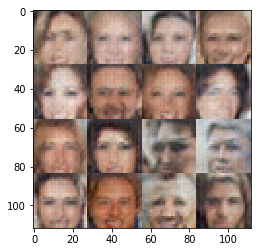

Epoch 0/1... Discriminator loss: 1.4442... Generator loss: 0.5946
Epoch 0/1... Discriminator loss: 1.4769... Generator loss: 0.6567
Epoch 0/1... Discriminator loss: 1.4053... Generator loss: 0.7386
Epoch 0/1... Discriminator loss: 1.3244... Generator loss: 0.6803
Epoch 0/1... Discriminator loss: 1.4414... Generator loss: 0.5747
Epoch 0/1... Discriminator loss: 1.3196... Generator loss: 0.6978
Epoch 0/1... Discriminator loss: 1.4366... Generator loss: 0.5934
Epoch 0/1... Discriminator loss: 1.1982... Generator loss: 0.8071
Epoch 0/1... Discriminator loss: 1.2604... Generator loss: 0.7903
Epoch 0/1... Discriminator loss: 1.4198... Generator loss: 0.6879


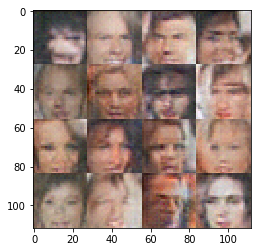

Epoch 0/1... Discriminator loss: 1.3250... Generator loss: 0.7086
Epoch 0/1... Discriminator loss: 1.4023... Generator loss: 0.6505
Epoch 0/1... Discriminator loss: 1.3647... Generator loss: 0.6592
Epoch 0/1... Discriminator loss: 1.3907... Generator loss: 0.6152
Epoch 0/1... Discriminator loss: 1.3952... Generator loss: 0.7087
Epoch 0/1... Discriminator loss: 1.4335... Generator loss: 0.6345
Epoch 0/1... Discriminator loss: 1.3390... Generator loss: 0.6695
Epoch 0/1... Discriminator loss: 1.2622... Generator loss: 0.7537
Epoch 0/1... Discriminator loss: 1.3711... Generator loss: 0.7329
Epoch 0/1... Discriminator loss: 1.2857... Generator loss: 0.7612


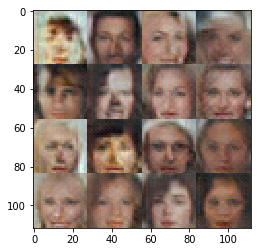

Epoch 0/1... Discriminator loss: 1.4274... Generator loss: 0.5764
Epoch 0/1... Discriminator loss: 1.4090... Generator loss: 0.6402
Epoch 0/1... Discriminator loss: 1.3276... Generator loss: 0.7257
Epoch 0/1... Discriminator loss: 1.4539... Generator loss: 0.5829
Epoch 0/1... Discriminator loss: 1.3235... Generator loss: 0.6960
Epoch 0/1... Discriminator loss: 1.4580... Generator loss: 0.6315
Epoch 0/1... Discriminator loss: 1.4070... Generator loss: 0.6662
Epoch 0/1... Discriminator loss: 1.3249... Generator loss: 0.7034
Epoch 0/1... Discriminator loss: 1.2777... Generator loss: 0.7078
Epoch 0/1... Discriminator loss: 1.2655... Generator loss: 0.8449


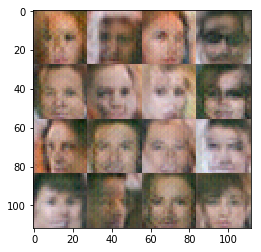

Epoch 0/1... Discriminator loss: 1.3313... Generator loss: 0.6583
Epoch 0/1... Discriminator loss: 1.4260... Generator loss: 0.5877
Epoch 0/1... Discriminator loss: 1.4466... Generator loss: 0.6633
Epoch 0/1... Discriminator loss: 1.4479... Generator loss: 0.6000
Epoch 0/1... Discriminator loss: 1.6516... Generator loss: 0.4351
Epoch 0/1... Discriminator loss: 1.3611... Generator loss: 0.6101
Epoch 0/1... Discriminator loss: 1.3193... Generator loss: 0.8525
Epoch 0/1... Discriminator loss: 1.1815... Generator loss: 0.8934
Epoch 0/1... Discriminator loss: 1.1496... Generator loss: 0.9193
Epoch 0/1... Discriminator loss: 1.1313... Generator loss: 0.8447


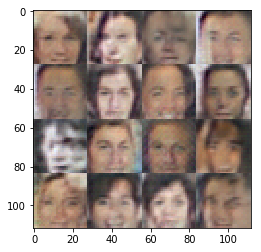

Epoch 0/1... Discriminator loss: 1.3046... Generator loss: 0.7742
Epoch 0/1... Discriminator loss: 1.2582... Generator loss: 0.7118
Epoch 0/1... Discriminator loss: 1.2405... Generator loss: 0.5395
Epoch 0/1... Discriminator loss: 0.4384... Generator loss: 1.3683
Epoch 0/1... Discriminator loss: 1.3708... Generator loss: 0.3559
Epoch 0/1... Discriminator loss: 0.9529... Generator loss: 0.7364
Epoch 0/1... Discriminator loss: 0.1539... Generator loss: 3.8510
Epoch 0/1... Discriminator loss: 2.6171... Generator loss: 7.5632
Epoch 0/1... Discriminator loss: 1.2350... Generator loss: 0.6045
Epoch 0/1... Discriminator loss: 1.1125... Generator loss: 0.5492


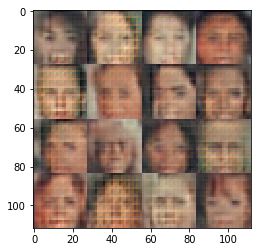

Epoch 0/1... Discriminator loss: 0.4251... Generator loss: 1.7433
Epoch 0/1... Discriminator loss: 1.4136... Generator loss: 0.3713
Epoch 0/1... Discriminator loss: 0.2570... Generator loss: 2.5889
Epoch 0/1... Discriminator loss: 1.0640... Generator loss: 4.3395
Epoch 0/1... Discriminator loss: 1.1660... Generator loss: 2.7072
Epoch 0/1... Discriminator loss: 2.7405... Generator loss: 0.0906
Epoch 0/1... Discriminator loss: 1.0633... Generator loss: 1.0536
Epoch 0/1... Discriminator loss: 0.9350... Generator loss: 0.7709
Epoch 0/1... Discriminator loss: 1.0403... Generator loss: 0.6229
Epoch 0/1... Discriminator loss: 1.0560... Generator loss: 0.9060


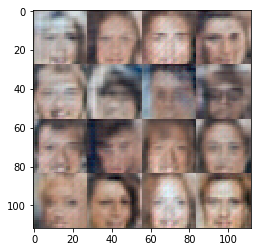

Epoch 0/1... Discriminator loss: 0.9627... Generator loss: 0.8521
Epoch 0/1... Discriminator loss: 0.4519... Generator loss: 1.6406
Epoch 0/1... Discriminator loss: 1.3070... Generator loss: 0.5551
Epoch 0/1... Discriminator loss: 1.4303... Generator loss: 0.4763
Epoch 0/1... Discriminator loss: 1.7322... Generator loss: 0.6812
Epoch 0/1... Discriminator loss: 1.3047... Generator loss: 0.6707
Epoch 0/1... Discriminator loss: 1.2713... Generator loss: 0.5213
Epoch 0/1... Discriminator loss: 1.0113... Generator loss: 1.2526
Epoch 0/1... Discriminator loss: 1.1919... Generator loss: 0.7656
Epoch 0/1... Discriminator loss: 1.4118... Generator loss: 0.6965


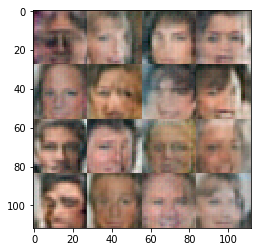

Epoch 0/1... Discriminator loss: 1.2105... Generator loss: 0.9850
Epoch 0/1... Discriminator loss: 1.3456... Generator loss: 0.5289
Epoch 0/1... Discriminator loss: 1.4216... Generator loss: 0.6787
Epoch 0/1... Discriminator loss: 1.4894... Generator loss: 0.4989
Epoch 0/1... Discriminator loss: 1.2672... Generator loss: 0.7328
Epoch 0/1... Discriminator loss: 1.4180... Generator loss: 0.6844
Epoch 0/1... Discriminator loss: 1.2292... Generator loss: 0.7050
Epoch 0/1... Discriminator loss: 1.3598... Generator loss: 0.5646
Epoch 0/1... Discriminator loss: 1.4529... Generator loss: 0.4893
Epoch 0/1... Discriminator loss: 1.2555... Generator loss: 0.6661


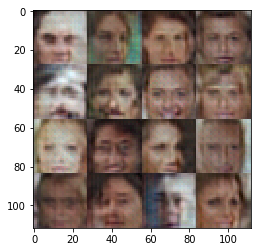

Epoch 0/1... Discriminator loss: 1.5099... Generator loss: 0.5932
Epoch 0/1... Discriminator loss: 1.3449... Generator loss: 0.7163
Epoch 0/1... Discriminator loss: 1.3847... Generator loss: 0.7240
Epoch 0/1... Discriminator loss: 1.4659... Generator loss: 0.5619
Epoch 0/1... Discriminator loss: 1.2391... Generator loss: 0.7726
Epoch 0/1... Discriminator loss: 1.3457... Generator loss: 0.5381
Epoch 0/1... Discriminator loss: 1.1323... Generator loss: 0.8299
Epoch 0/1... Discriminator loss: 1.1948... Generator loss: 0.7227
Epoch 0/1... Discriminator loss: 1.2757... Generator loss: 0.6904
Epoch 0/1... Discriminator loss: 1.4187... Generator loss: 0.4533


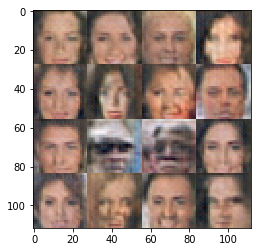

Epoch 0/1... Discriminator loss: 1.4992... Generator loss: 0.5734
Epoch 0/1... Discriminator loss: 1.4391... Generator loss: 0.4663
Epoch 0/1... Discriminator loss: 1.3266... Generator loss: 0.6493
Epoch 0/1... Discriminator loss: 1.2578... Generator loss: 0.7025
Epoch 0/1... Discriminator loss: 1.5502... Generator loss: 0.5618
Epoch 0/1... Discriminator loss: 1.4217... Generator loss: 0.6004
Epoch 0/1... Discriminator loss: 1.3782... Generator loss: 0.6675
Epoch 0/1... Discriminator loss: 1.4613... Generator loss: 0.5981
Epoch 0/1... Discriminator loss: 1.2393... Generator loss: 0.7191
Epoch 0/1... Discriminator loss: 1.4799... Generator loss: 0.6003


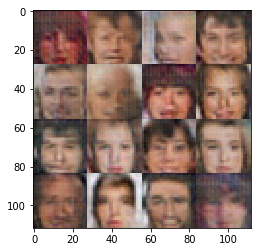

Epoch 0/1... Discriminator loss: 1.5080... Generator loss: 0.5554
Epoch 0/1... Discriminator loss: 1.3646... Generator loss: 0.6196
Epoch 0/1... Discriminator loss: 1.4429... Generator loss: 0.6645
Epoch 0/1... Discriminator loss: 1.4679... Generator loss: 0.5492
Epoch 0/1... Discriminator loss: 1.5135... Generator loss: 0.5855
Epoch 0/1... Discriminator loss: 1.2967... Generator loss: 0.6963
Epoch 0/1... Discriminator loss: 1.4405... Generator loss: 0.5357
Epoch 0/1... Discriminator loss: 1.3282... Generator loss: 0.6992
Epoch 0/1... Discriminator loss: 1.3815... Generator loss: 0.5654
Epoch 0/1... Discriminator loss: 1.3353... Generator loss: 0.6040


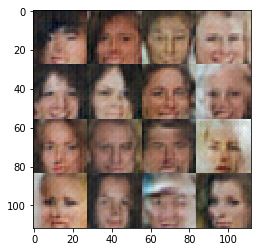

Epoch 0/1... Discriminator loss: 1.4117... Generator loss: 0.6634
Epoch 0/1... Discriminator loss: 1.3743... Generator loss: 0.6005
Epoch 0/1... Discriminator loss: 1.3276... Generator loss: 0.6153
Epoch 0/1... Discriminator loss: 1.4854... Generator loss: 0.5720
Epoch 0/1... Discriminator loss: 1.3772... Generator loss: 0.6299
Epoch 0/1... Discriminator loss: 1.4587... Generator loss: 0.6605
Epoch 0/1... Discriminator loss: 1.3906... Generator loss: 0.6950
Epoch 0/1... Discriminator loss: 1.2850... Generator loss: 0.6969
Epoch 0/1... Discriminator loss: 1.3068... Generator loss: 0.6572
Epoch 0/1... Discriminator loss: 1.3731... Generator loss: 0.6259


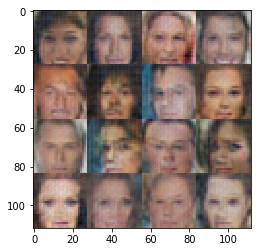

Epoch 0/1... Discriminator loss: 1.3595... Generator loss: 0.6530
Epoch 0/1... Discriminator loss: 1.5397... Generator loss: 0.5546
Epoch 0/1... Discriminator loss: 1.2525... Generator loss: 0.7286
Epoch 0/1... Discriminator loss: 1.1372... Generator loss: 0.7483
Epoch 0/1... Discriminator loss: 1.4606... Generator loss: 0.6430
Epoch 0/1... Discriminator loss: 1.4987... Generator loss: 0.5181
Epoch 0/1... Discriminator loss: 1.4981... Generator loss: 0.5856
Epoch 0/1... Discriminator loss: 1.4180... Generator loss: 0.6812
Epoch 0/1... Discriminator loss: 1.3177... Generator loss: 0.6826
Epoch 0/1... Discriminator loss: 1.4786... Generator loss: 0.5783


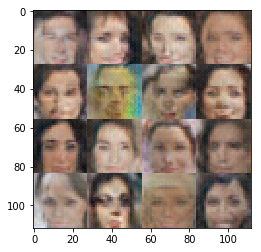

Epoch 0/1... Discriminator loss: 1.4252... Generator loss: 0.6169
Epoch 0/1... Discriminator loss: 1.3276... Generator loss: 0.6142
Epoch 0/1... Discriminator loss: 1.4244... Generator loss: 0.6313
Epoch 0/1... Discriminator loss: 1.1791... Generator loss: 0.8031
Epoch 0/1... Discriminator loss: 1.1999... Generator loss: 0.7744
Epoch 0/1... Discriminator loss: 1.3634... Generator loss: 0.6510
Epoch 0/1... Discriminator loss: 1.3423... Generator loss: 0.6231
Epoch 0/1... Discriminator loss: 1.4617... Generator loss: 0.5251
Epoch 0/1... Discriminator loss: 1.5275... Generator loss: 0.6022
Epoch 0/1... Discriminator loss: 1.5998... Generator loss: 0.4910


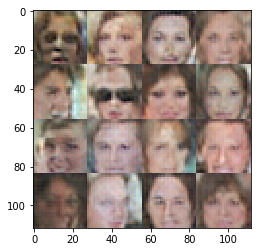

Epoch 0/1... Discriminator loss: 1.4493... Generator loss: 0.5861
Epoch 0/1... Discriminator loss: 1.4590... Generator loss: 0.6662
Epoch 0/1... Discriminator loss: 1.3438... Generator loss: 0.6819
Epoch 0/1... Discriminator loss: 1.3633... Generator loss: 0.6962
Epoch 0/1... Discriminator loss: 1.3826... Generator loss: 0.6885
Epoch 0/1... Discriminator loss: 1.3683... Generator loss: 0.7656
Epoch 0/1... Discriminator loss: 1.4068... Generator loss: 0.6528
Epoch 0/1... Discriminator loss: 1.3302... Generator loss: 0.6195
Epoch 0/1... Discriminator loss: 1.4098... Generator loss: 0.5772
Epoch 0/1... Discriminator loss: 1.3343... Generator loss: 0.7027


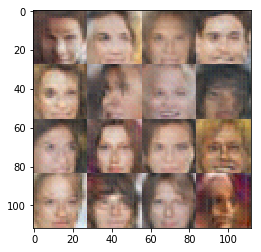

Epoch 0/1... Discriminator loss: 1.4207... Generator loss: 0.6016
Epoch 0/1... Discriminator loss: 1.5489... Generator loss: 0.5103
Epoch 0/1... Discriminator loss: 1.4689... Generator loss: 0.6084
Epoch 0/1... Discriminator loss: 1.3107... Generator loss: 0.6560
Epoch 0/1... Discriminator loss: 1.4609... Generator loss: 0.5433
Epoch 0/1... Discriminator loss: 1.3118... Generator loss: 0.6557
Epoch 0/1... Discriminator loss: 1.2879... Generator loss: 0.6391
Epoch 0/1... Discriminator loss: 1.3951... Generator loss: 0.6721
Epoch 0/1... Discriminator loss: 1.3356... Generator loss: 0.6486
Epoch 0/1... Discriminator loss: 1.2655... Generator loss: 0.6836


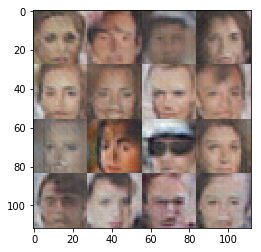

Epoch 0/1... Discriminator loss: 1.2876... Generator loss: 0.6296
Epoch 0/1... Discriminator loss: 1.4186... Generator loss: 0.5887
Epoch 0/1... Discriminator loss: 1.4186... Generator loss: 0.6572
Epoch 0/1... Discriminator loss: 1.4104... Generator loss: 0.6370
Epoch 0/1... Discriminator loss: 1.4816... Generator loss: 0.5240
Epoch 0/1... Discriminator loss: 1.1731... Generator loss: 0.7572
Epoch 0/1... Discriminator loss: 1.3068... Generator loss: 0.6249
Epoch 0/1... Discriminator loss: 1.3542... Generator loss: 0.6613
Epoch 0/1... Discriminator loss: 1.4201... Generator loss: 0.5845
Epoch 0/1... Discriminator loss: 1.3322... Generator loss: 0.7369


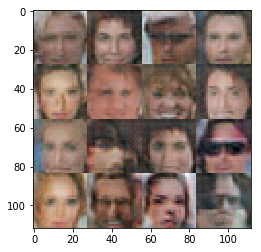

Epoch 0/1... Discriminator loss: 1.4473... Generator loss: 0.6127
Epoch 0/1... Discriminator loss: 1.4492... Generator loss: 0.5661
Epoch 0/1... Discriminator loss: 1.3824... Generator loss: 0.6492


In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.